## Data Cleaning & EDA

### Problem Statement



Import libraries

In [997]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

plt.rcParams['figure.figsize'] = (15, 9)
plt.rcParams.update({'font.size': 14})
sns.set_style("whitegrid")

### Data Query

Using the [JPL Small-Body Database Search Engine](https://ssd.jpl.nasa.gov/sbdb_query.cgi#x) I was able to generate a custom table of orbital and physical parameters for asteroids. I specified search constraints like
object type/group, orbit class, and object characteristics as well as output fields like orbital parameters.

**Note:** All distance units are in astronomical units unless otherwise specified.

### Import Data

In [1010]:
df = pd.read_csv('../data/NASA-asteroids.csv')

In [1011]:
df.head()

,name,neo,pha,epoch_cal,equinox,e,a,q,i,w,...,t_jup,om,per,per_y,class,producer,first_obs,last_obs,diameter,albedo
0,Eros,Y,N,20200531.0,J2000,0.222951,1.458046,1.132973,10.830543,178.882294,...,4.582,304.299327,643.065402,1.760617,AMO,Giorgini,1893-10-29,2019-02-13,16.840,0.250
1,Albert,Y,N,20200531.0,J2000,0.546558,2.638602,1.196452,11.567485,156.176338,...,3.140,183.866950,1565.522356,4.286167,AMO,Otto Matic,1911-10-04,2020-02-27,NaN,NaN
2,Alinda,Y,N,20200531.0,J2000,0.570332,2.473737,1.062886,9.393854,350.495585,...,3.221,110.434218,1421.113276,3.890796,AMO,Otto Matic,1918-02-03,2019-08-27,4.200,0.310
3,Ganymed,Y,N,20200531.0,J2000,0.533046,2.664725,1.244303,26.677643,132.364631,...,3.035,215.546826,1588.828164,4.349974,AMO,Otto Matic,1924-10-23,2019-08-17,37.675,0.238
4,Amor,Y,N,20200531.0,J2000,0.435285,1.919498,1.083970,11.876536,26.694797,...,3.781,171.326998,971.359460,2.659437,AMO,Otto Matic,1932-03-12,2020-01-24,1.000,NaN


In [1012]:
df.shape

(2917, 25)

**Color Theme List**  
I am creating a list of colors to use throughout my notebooks

In [1013]:
# Create colors list
c = ['#B275FF', '#757DFF', '#5E3BA8', '#503098', '#41258A', '#251C65']

### Rename Columns

In [1014]:
# Create column name dictionary to rename columns
column_names = {
    'pha': 'hazardous',
    'e': 'eccentricity_(e)',
    'a': 'semi_major_axis_(a)',
    'q': 'perihelion_dist_(q)',
    'i': 'inclination_(i)',
    'w': 'perihelion_arg_(w)',
    'H': 'abs_magnitude_(H)',
    'ma': 'mean_anomaly',
    'ad': 'aphelion_dist_(Q)',
    'n': 'mean_motion_(n)',
    'moid': 'min_orbit_intersection_dist',
    't_jup': 't_jupiter',
    'per': 'orbital_per_(d)',
    'per_y': 'orbital_per_(y)',
    'om': 'asc_node_long_(deg)',
    'diameter': 'diameter_(km)'
}

# Rename columns
df.rename(columns=column_names, inplace=True)

### Analyze Missing Values

I am analyzing missing values to decide which to drop or impute.

**Drop Missing Values**  

The `name` and `full_name` columns are neither quantitative nor qualitative features for the model so I'm deciding to drop them. The column `producer` tells who first observed the asteroid, and although it is important, it will not be necessary for the model. The column `equinox` contains the same value for every observation so it is also not relevant to the model. When it comes to `diameter` and `albedo`, more than 60% of the observations are missing therefore, I am dropping the columns altogether. Lastly, I will drop the `orbital_per_(d)` because there is a column containing the same information in years: `orbital_per_(y)`.

In [1015]:
# Check if there are null values
df.isnull().sum()

# Drop name column because it's a repitition of full_name column but with most values missing
# Drop producer because it's unbalanced and won't contribute to the model 
# Drop equinox because all observations have the same equinox 'J2000'
df.drop(columns=['name', 'producer', 'equinox'], inplace=True)

# 5442/df.shape[0]
df.drop(columns=['diameter_(km)', 'albedo'], inplace=True)

# Drop unecessary column
# df.drop(columns=['full_name'], inplace=True)

# Duplicate column for orbital_per_(y)
df.drop(columns='orbital_per_(d)', inplace=True)

# Verify there are no more missing values
df.isnull().sum()

neo                            0
hazardous                      0
epoch_cal                      0
eccentricity_(e)               0
semi_major_axis_(a)            0
perihelion_dist_(q)            0
inclination_(i)                0
perihelion_arg_(w)             0
abs_magnitude_(H)              0
mean_anomaly                   0
aphelion_dist_(Q)              0
mean_motion_(n)                0
min_orbit_intersection_dist    0
t_jupiter                      0
asc_node_long_(deg)            0
orbital_per_(y)                0
class                          0
first_obs                      0
last_obs                       0
dtype: int64

### Analyze Data Types

I am analyzing datatypes converting inaccurate ones or 'dummifying' categorical ones. There are two date columns that appear as objects so I am converting those to pandas datetime types. `Neo` is also listed as an object type so I will assign 1 to observations that are NEO's and 1 to those that are not NEO's. NEO's (Near Earth Objects), in terms of orbital elements, are asteroids with perihelion distance less than 1.3 au [[source]](https://cneos.jpl.nasa.gov/about/neo_groups.html). The target label: `hazardous` is also listed as an object type, so I am assigning a 1 to non-hazardous asteroids and a 1 to potentially hazardous asteroids.

In [1016]:
# Inspect the data types
df.dtypes

# Convert datetime columns to pandas datetime data types 
df['first_obs'] = pd.to_datetime(df['first_obs'])
df['last_obs'] = pd.to_datetime(df['last_obs'])

# Check that it worked
df.dtypes

# Assign target labels (hazardous)
# Assign NEO labels
df['hazardous'] = df['hazardous'].map({'Y': 1, 'N': 0})
df['neo'] = df['neo'].map({'Y': 1, 'N': 0})


# Check the balance of neo
df['neo'].value_counts(normalize=True)

# Check the balance of hazardous
df['hazardous'].value_counts()

0    2152
1     765
Name: hazardous, dtype: int64

The asteroid orbit classes in the data are IEO (Atiras), ATE (Aten), AMO (Amor), APO (Apollo), and TJN (Jupiter Trojan) which are classes that 

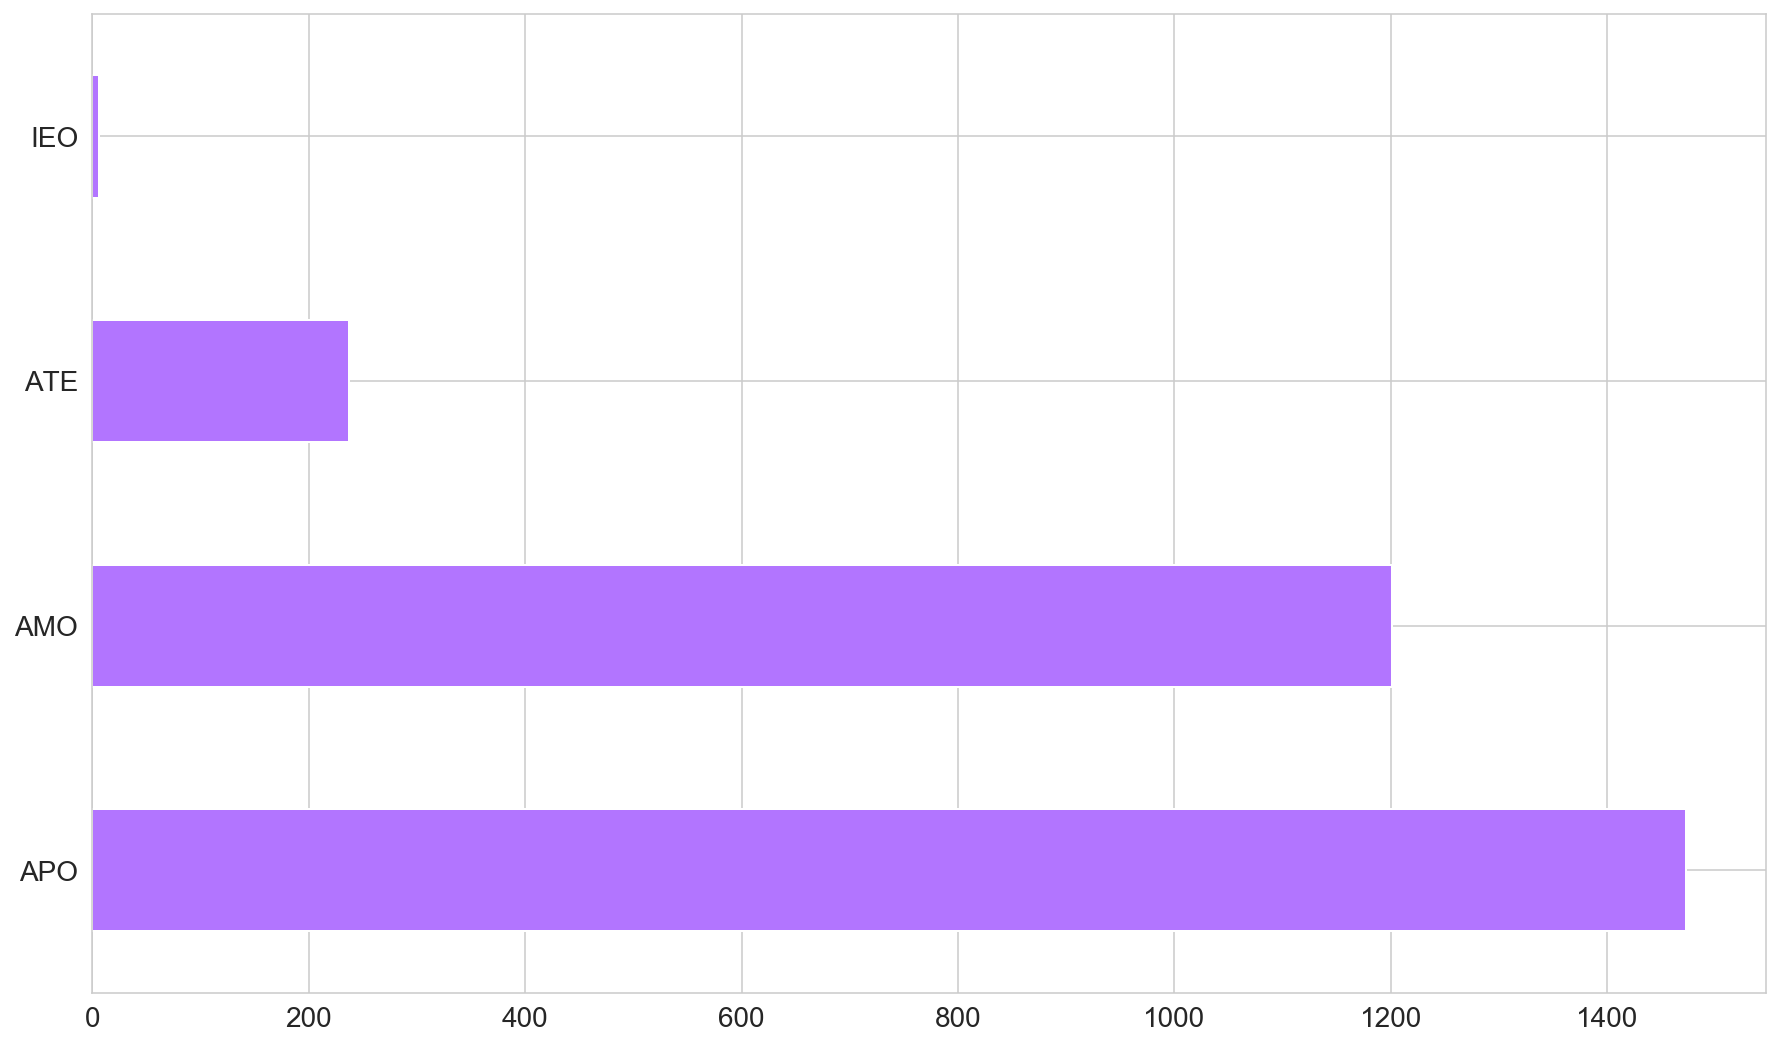

In [1017]:
# Check the balance of the asteroid orbit classes
df['class'].value_counts(normalize=True)

# Visual representation of orbital class distribution
df.sort_values(by='hazardous')['class'].value_counts().plot(kind='barh', color=c[0])
plt.savefig('../images/asteroid_orbit_class_dist.png');

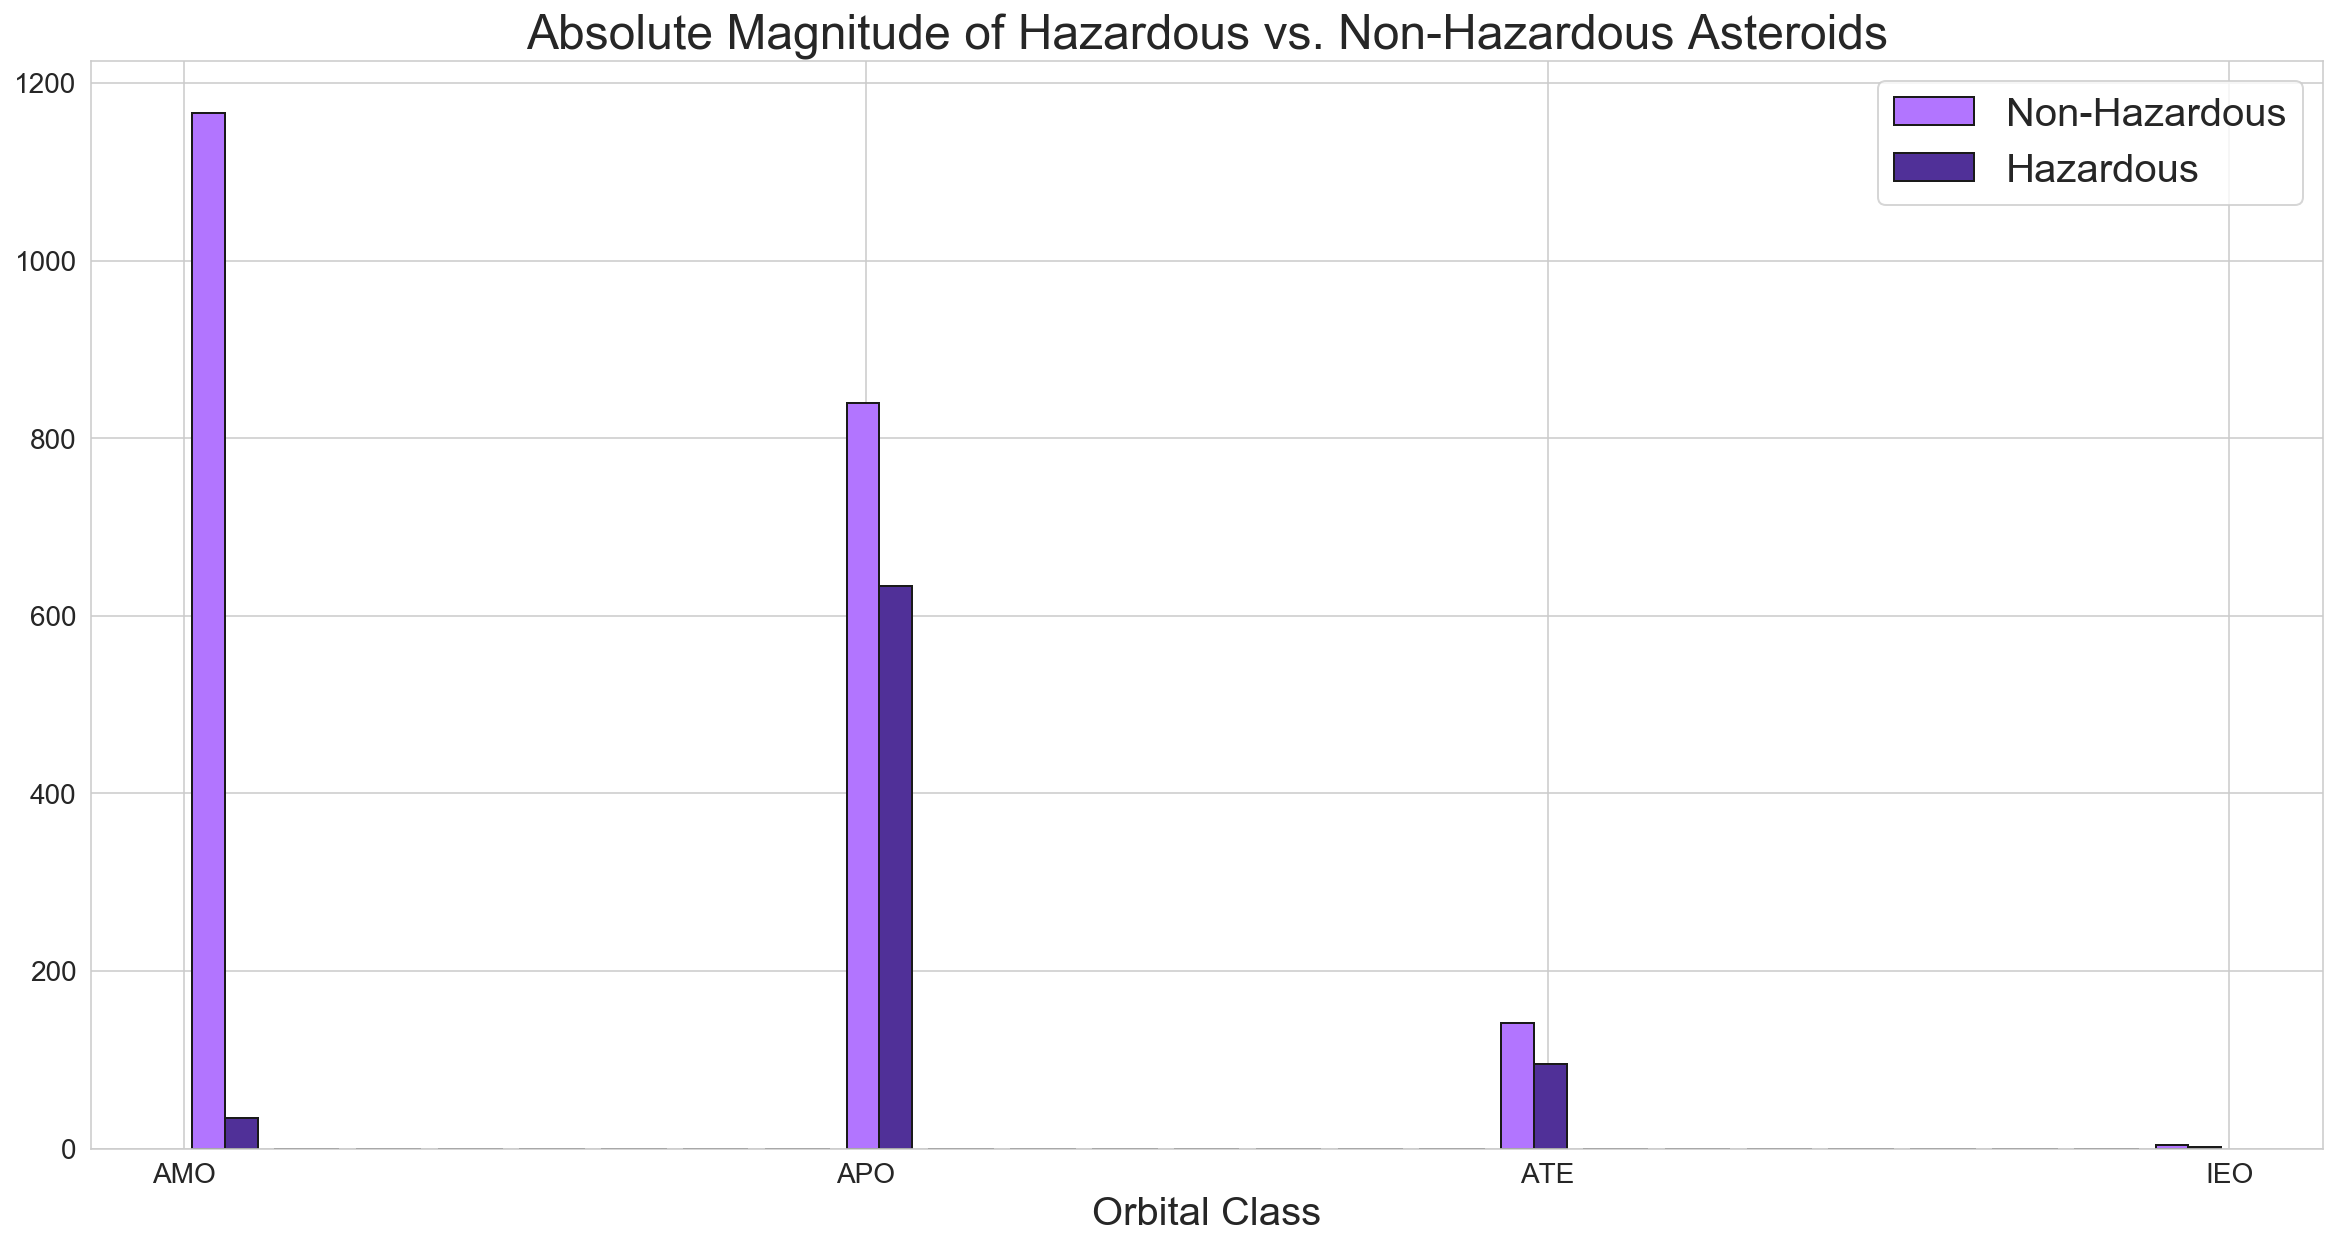

In [1018]:
plt.figure(figsize=(20,10))
plt.hist([df[df['hazardous']==0]['class'], 
          df[df['hazardous']==1]['class']],
         bins=25, color=[c[0], c[3]], ec='k')

plt.title('Absolute Magnitude of Hazardous vs. Non-Hazardous Asteroids', fontsize=24)
plt.xlabel('Orbital Class', fontsize=20)
plt.legend(['Non-Hazardous', 'Hazardous'], fontsize=20)
plt.savefig('../images/abs_mag_asteroic_class.png');

In [1019]:
df.groupby('class')['hazardous'].value_counts()

class  hazardous
AMO    0            1166
       1              35
APO    0             840
       1             633
ATE    0             142
       1              95
IEO    0               4
       1               2
Name: hazardous, dtype: int64

```class  hazardous  
AMO    0             8138
       1              119
APO    0            10559
       1             1750
ATE    0             1511
       1              174
IEO    0               15
       1                6
Name: hazardous, dtype: int64```

In [1020]:
df['hazardous'].value_counts(normalize=True)*100

0    73.774426
1    26.225574
Name: hazardous, dtype: float64

In [1021]:
# get dummies for each asteroid class
# AMO was dropped
df = pd.get_dummies(df, columns=['class'], drop_first=True)

df.head(1)

,neo,hazardous,epoch_cal,eccentricity_(e),semi_major_axis_(a),perihelion_dist_(q),inclination_(i),perihelion_arg_(w),abs_magnitude_(H),mean_anomaly,...,mean_motion_(n),min_orbit_intersection_dist,t_jupiter,asc_node_long_(deg),orbital_per_(y),first_obs,last_obs,class_APO,class_ATE,class_IEO
0,1,0,20200531.0,0.222951,1.458046,1.132973,10.830543,178.882294,10.4,271.071732,...,0.559819,0.148623,4.582,304.299327,1.760617,1893-10-29,2019-02-13,0,0,0


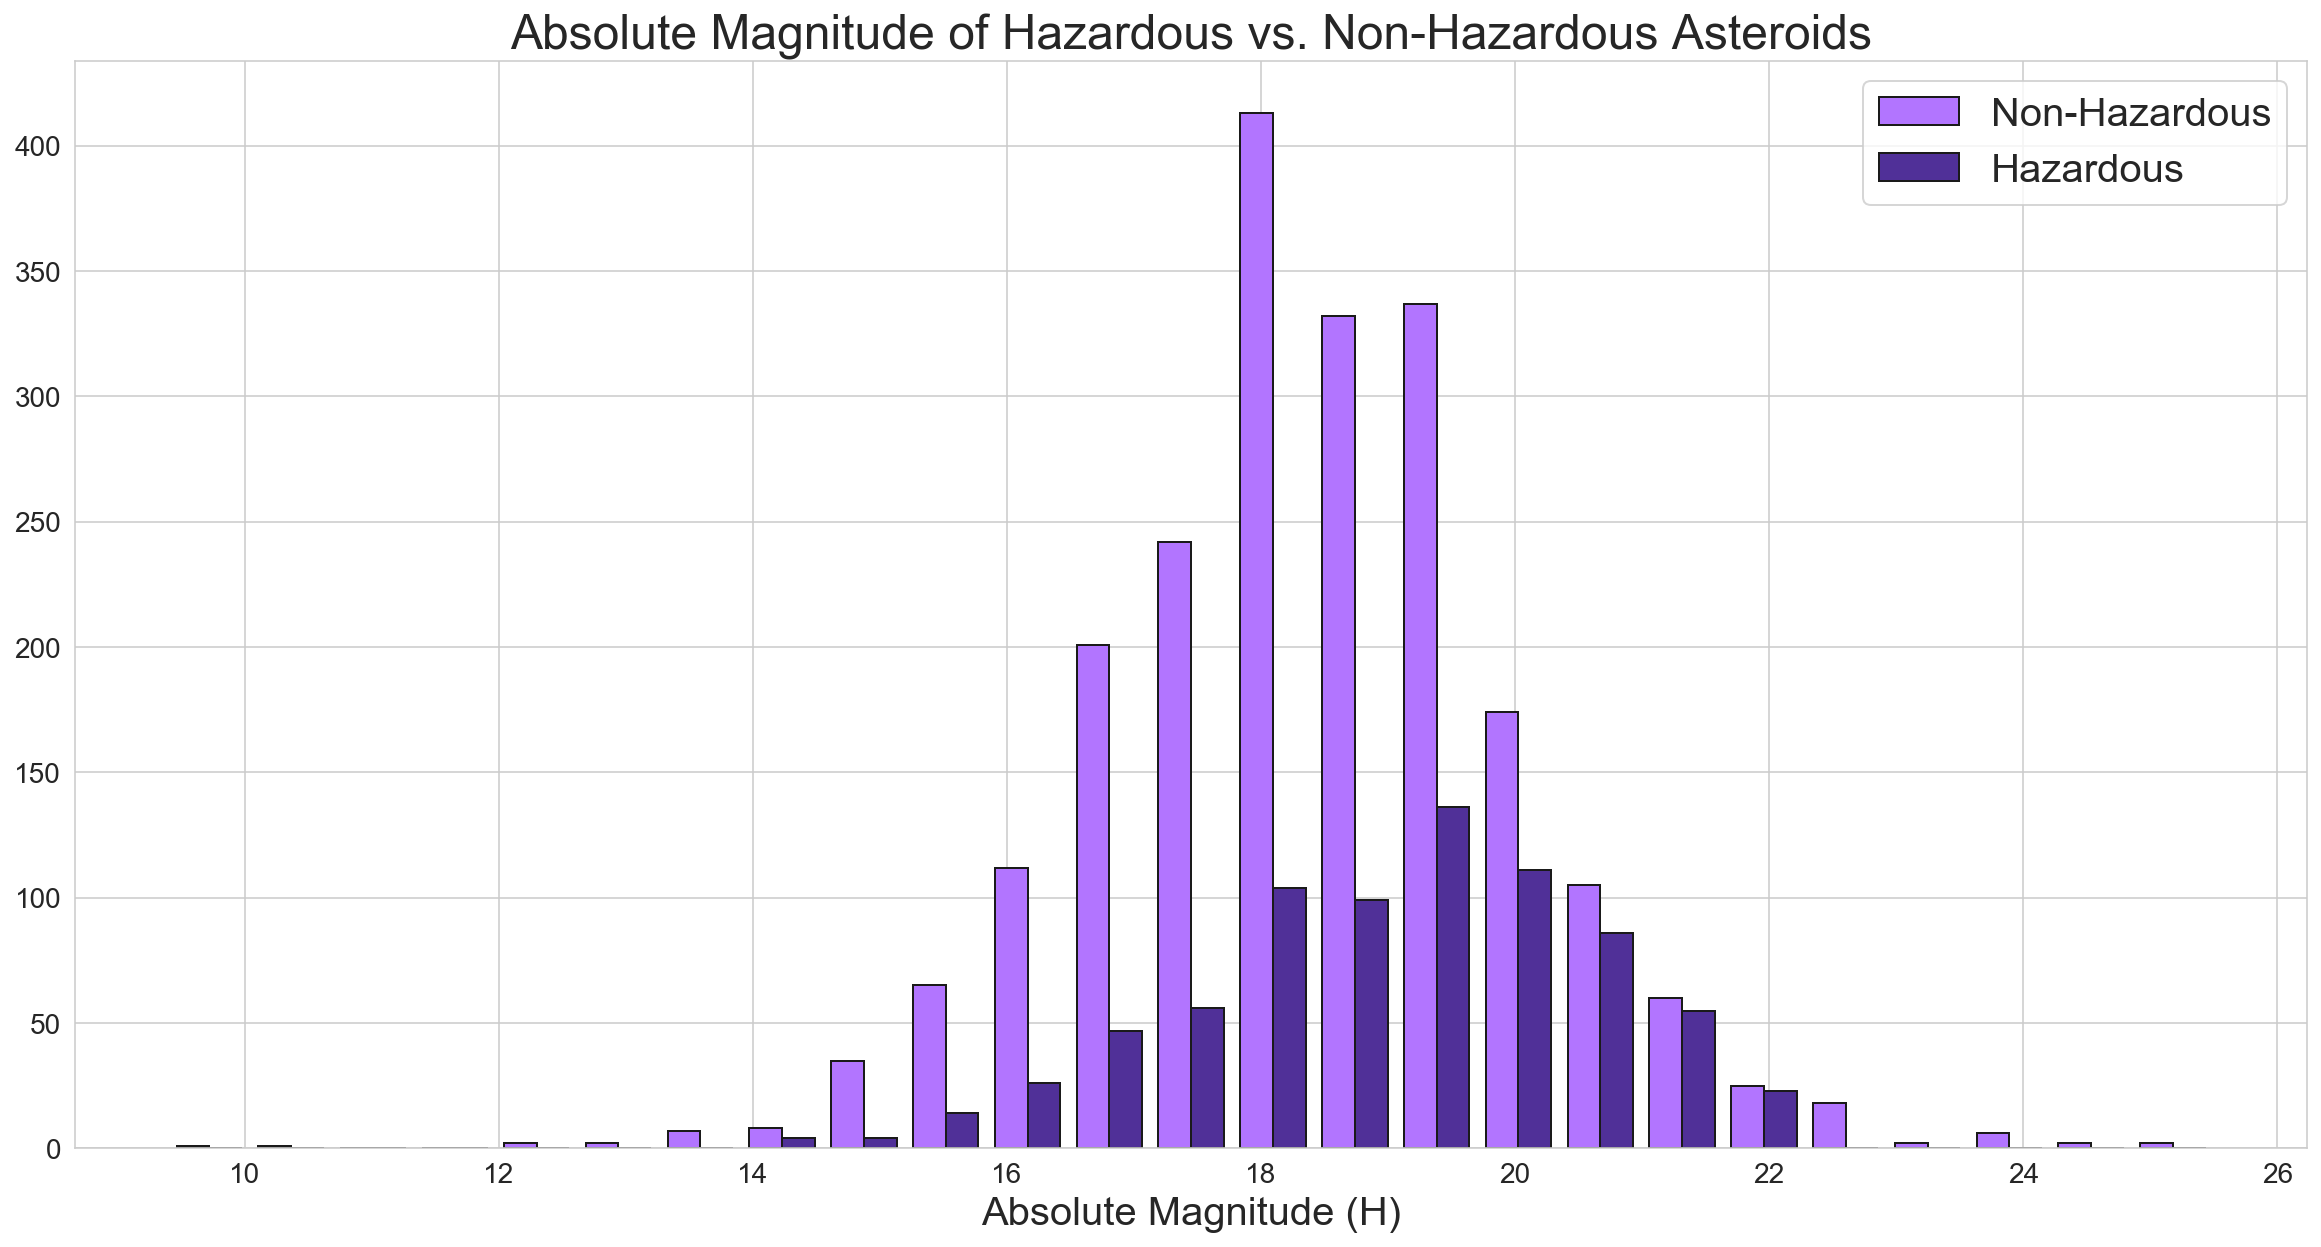

In [1022]:
plt.figure(figsize=(20,10))
plt.hist([df[df['hazardous']==0]['abs_magnitude_(H)'], 
          df[df['hazardous']==1]['abs_magnitude_(H)']],
         bins=25, color=[c[0], c[3]], ec='k')

plt.title('Absolute Magnitude of Hazardous vs. Non-Hazardous Asteroids', fontsize=24)
plt.xlabel('Absolute Magnitude (H)', fontsize=20)
plt.legend(['Non-Hazardous', 'Hazardous'], fontsize=20)
plt.savefig('../images/abs_mag.png');

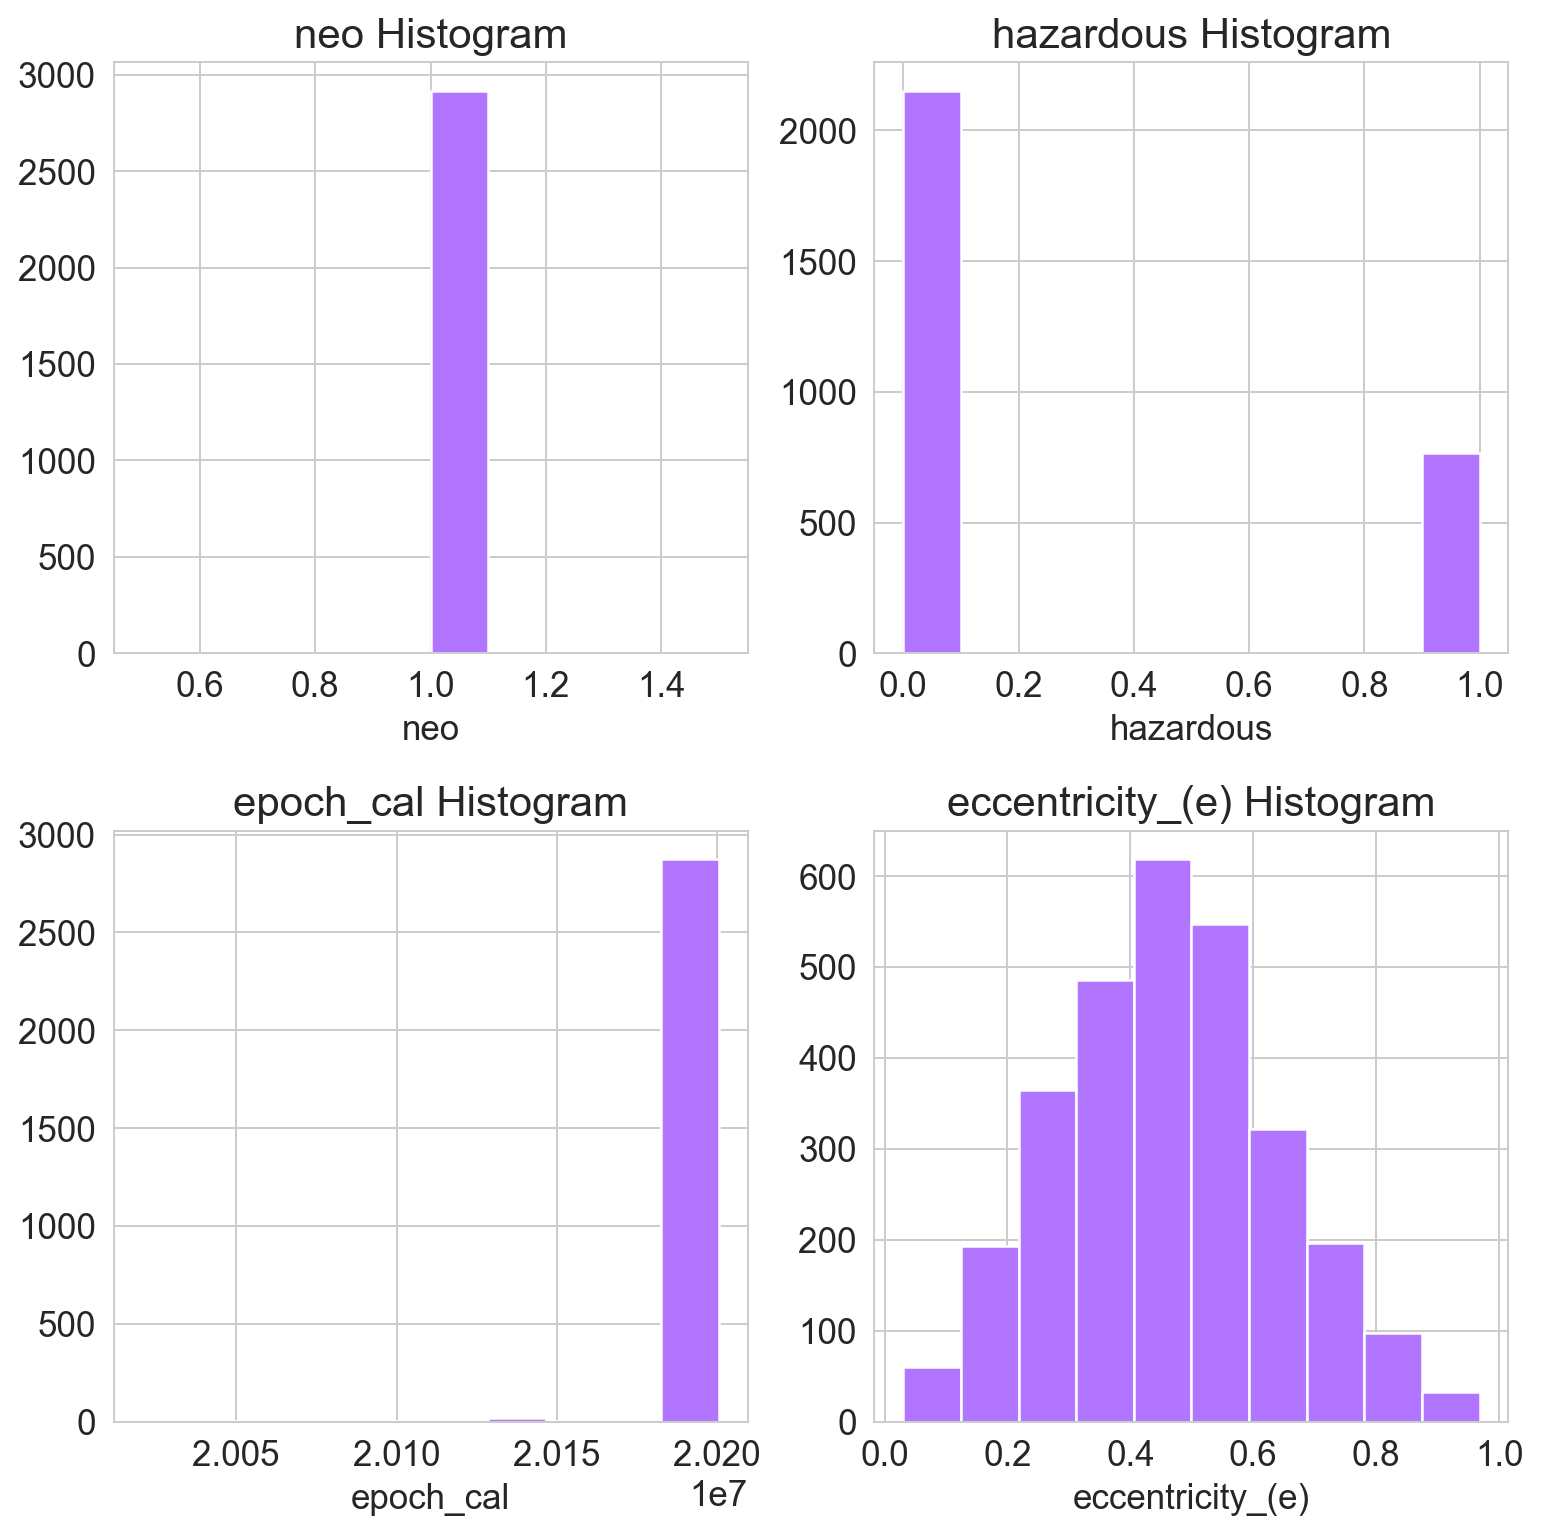

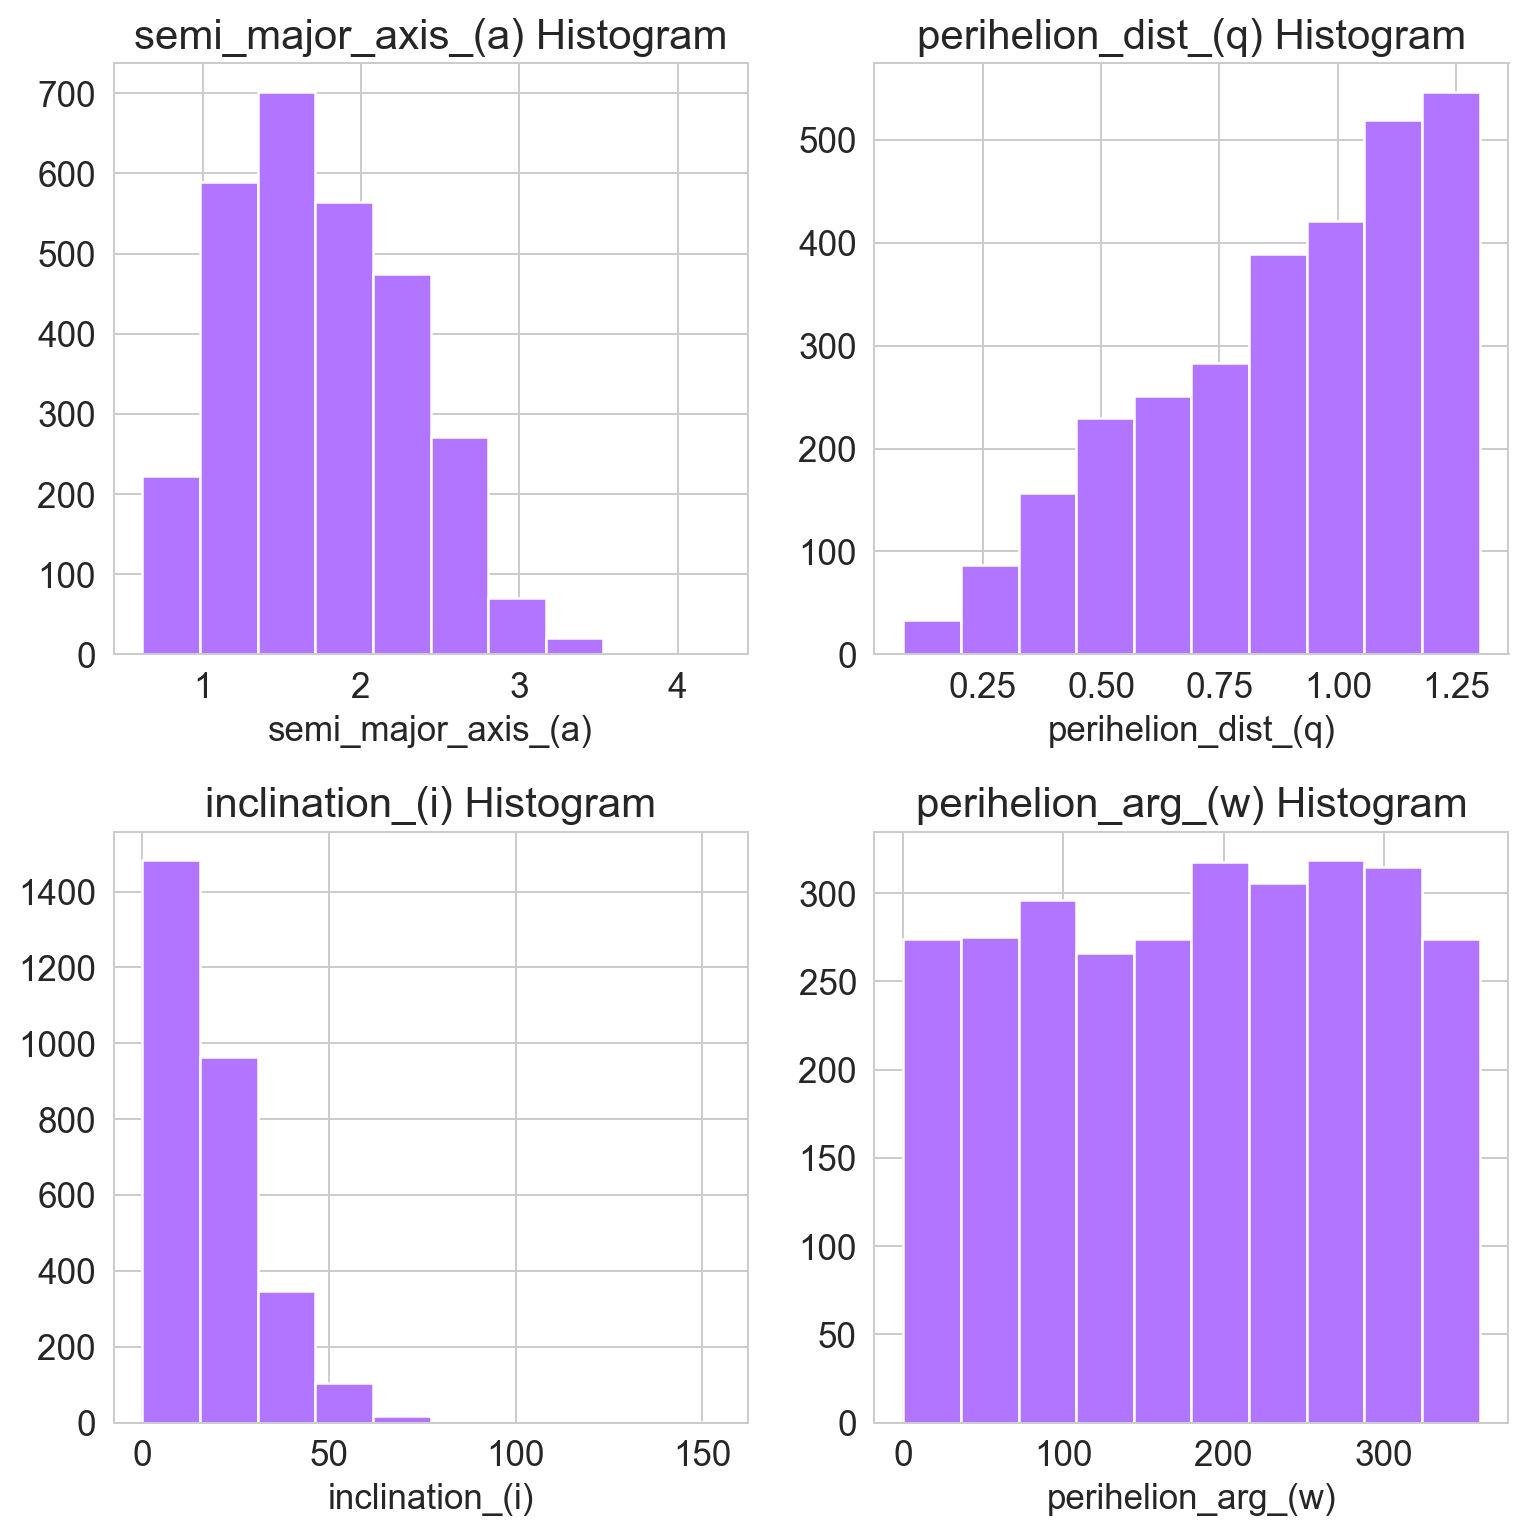

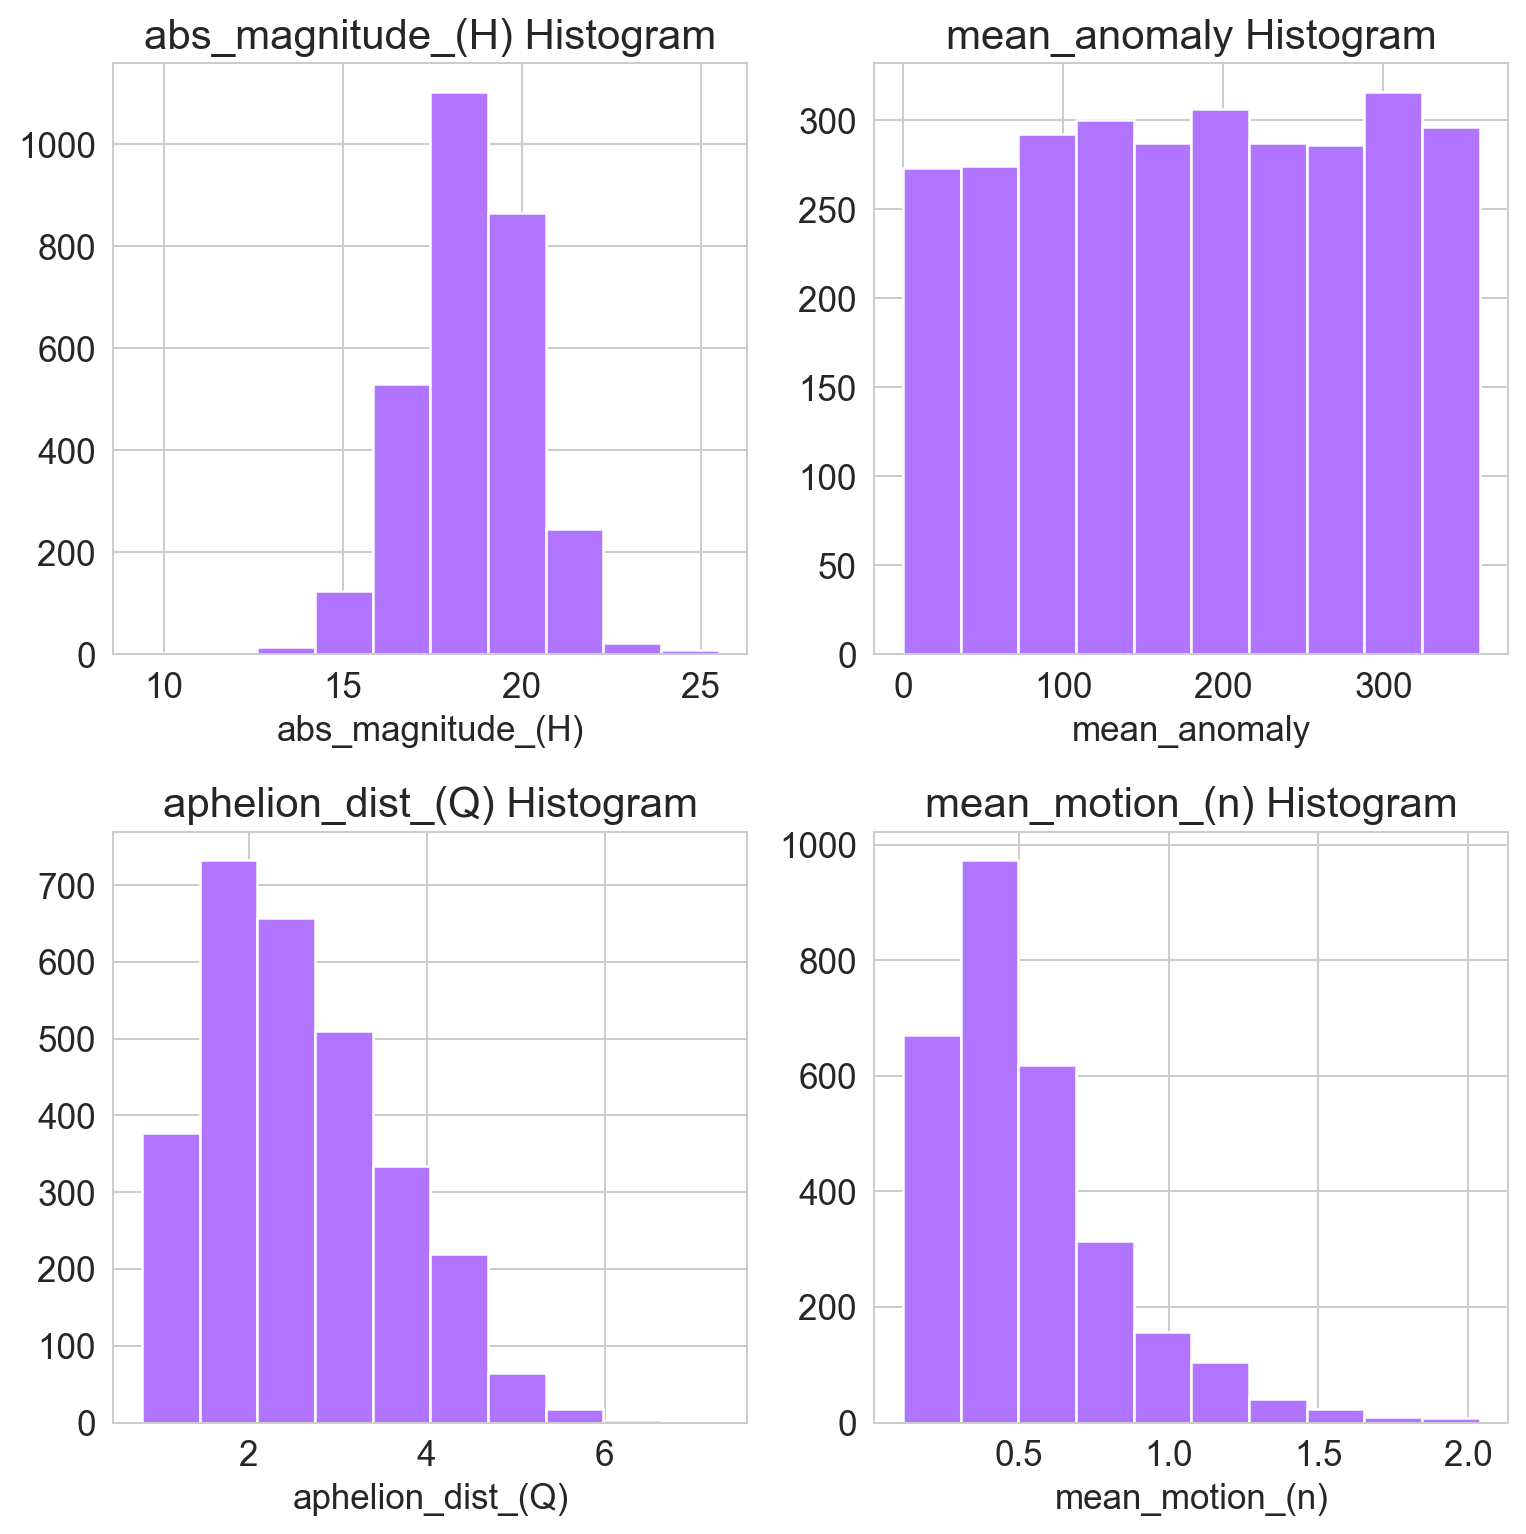

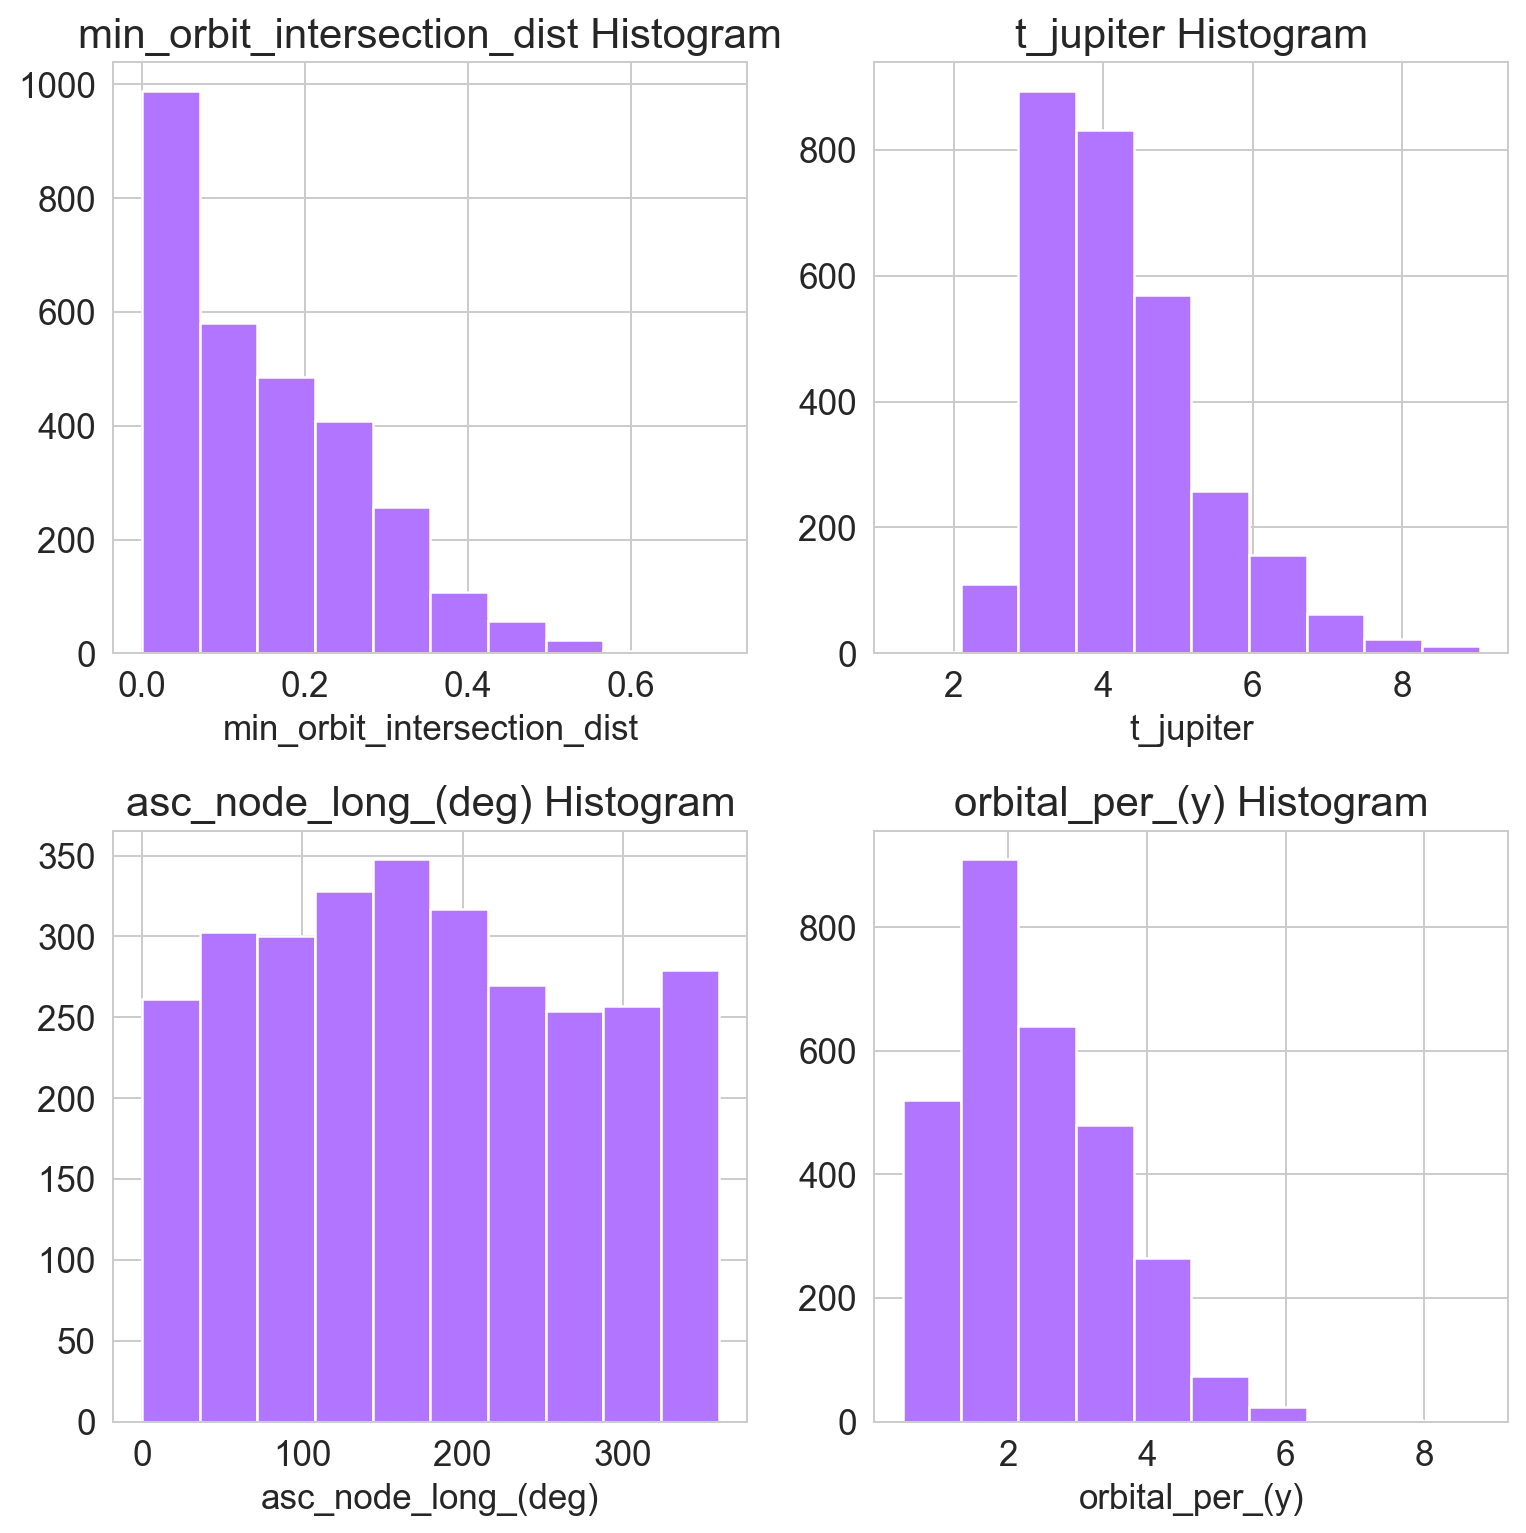

In [1023]:
# Create Function that plots histograms of four columns at a time
def subplot_histograms(dataframe, list_of_columns, list_of_titles, list_of_xlabels):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (10,10), dpi = 90) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    colors = [c[0], c[0], c[0], c[0]]
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        ax[i].hist(dataframe[column], color = colors[i]) # feel free to add more settings
        # Set titles, labels, etc for each subplot
    for i, title in enumerate(list_of_titles):
        ax[i].set(title=f'{title} Histogram')
    for i, xlabel in enumerate(list_of_xlabels):
        ax[i].set(xlabel=xlabel)
    plt.subplots_adjust(hspace=0.3)

# Histogram Graphs
subplot_histograms(df,
                   ['neo', 'hazardous', 'epoch_cal', 'eccentricity_(e)'],
                   ['neo', 'hazardous', 'epoch_cal', 'eccentricity_(e)'],
                   ['neo', 'hazardous', 'epoch_cal', 'eccentricity_(e)']
                  )


subplot_histograms(df,
                   ['semi_major_axis_(a)', 'perihelion_dist_(q)', 'inclination_(i)', 'perihelion_arg_(w)'],
                   ['semi_major_axis_(a)', 'perihelion_dist_(q)', 'inclination_(i)', 'perihelion_arg_(w)'],
                   ['semi_major_axis_(a)', 'perihelion_dist_(q)', 'inclination_(i)', 'perihelion_arg_(w)']
                  )


subplot_histograms(df,
                  ['abs_magnitude_(H)', 'mean_anomaly', 'aphelion_dist_(Q)', 'mean_motion_(n)'],
                  ['abs_magnitude_(H)', 'mean_anomaly', 'aphelion_dist_(Q)', 'mean_motion_(n)'],
                  ['abs_magnitude_(H)', 'mean_anomaly', 'aphelion_dist_(Q)', 'mean_motion_(n)']
                  )


subplot_histograms(df,
                  ['min_orbit_intersection_dist', 't_jupiter', 'asc_node_long_(deg)', 'orbital_per_(y)'],
                  ['min_orbit_intersection_dist', 't_jupiter', 'asc_node_long_(deg)', 'orbital_per_(y)'],
                  ['min_orbit_intersection_dist', 't_jupiter', 'asc_node_long_(deg)', 'orbital_per_(y)'])

>Based on the histograms, most of the features are not normally distributed, which not surprising coming from asteroids. The `hazardous` target is highly unbalanced where there are many more observations for non-hazardous asteroids. The `neo` categories are also slightly unbalanced where there are more observations for non-neo's. When it comes to eccentricity, the majority of observations have a lower eccentricity value from 0 to 0.1 and the rest are more normally distributed from 0.2 - 1.0. 

### Box Plot Graphs

Check distribution of features with quick box plot graphs.

<Figure size 1080x648 with 0 Axes>

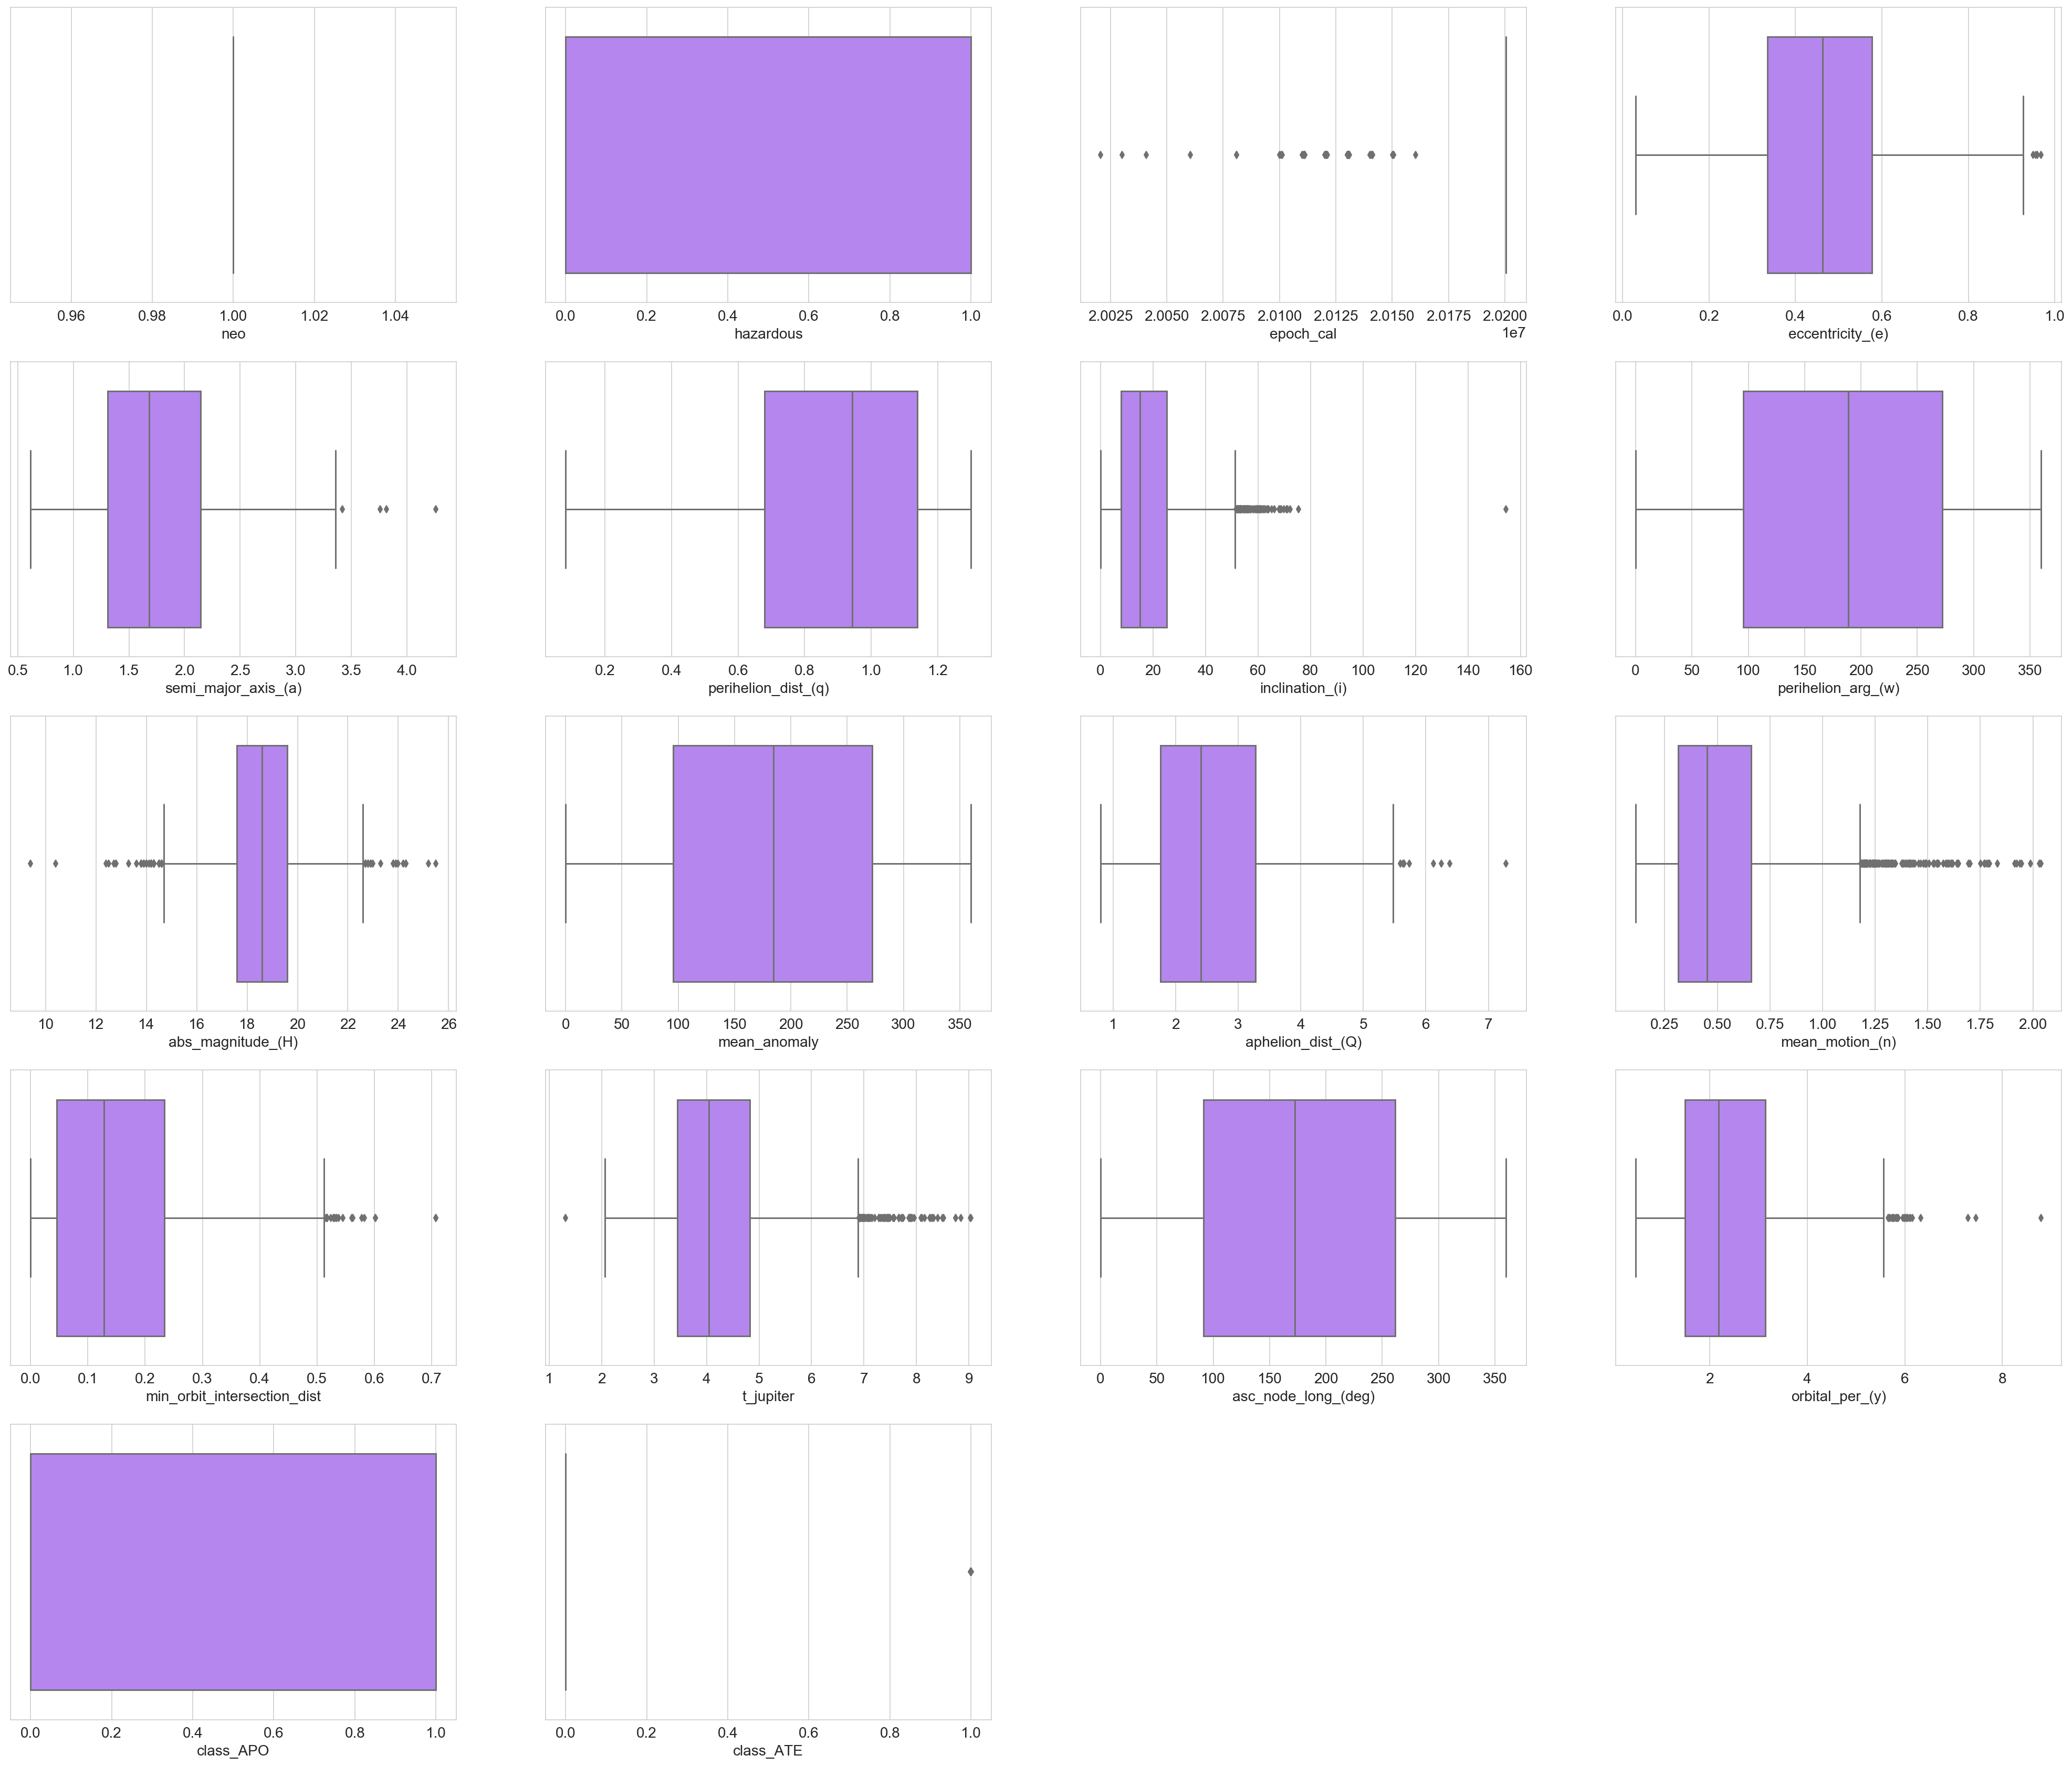

In [1024]:
# Make a data frame with only numberic columns
df_numeric = df.describe().columns

plt.tight_layout(pad=0.9)
plt.figure(figsize=(35,30)); 
plt.subplots_adjust(wspace = 0.2)
number_columns = 4 
number_graphs = len(df_numeric) 
number_rows = int(np.ceil(number_graphs/number_columns)) 
columns = list(df[df_numeric].columns.values); 

for i in range(0,len(columns)-1): 
    plt.subplot(number_rows, number_columns, i+1) 
    ax1=sns.boxplot(x= columns[i], data= df[df_numeric], orient="h", color=c[0]);

>The columns with the most outliers are the jupiter tisserand parameter, mean motion, epoch, and the orbital classes. The outliers obstruct the views of the distributions and therefore, the histograms are a better visual of the distributions.

In [1025]:
def plot_scatterplot(dataframe, list_of_columns, title, xlabel, ylabel):
    plt.figure(figsize=(8, 5), dpi=80)
    plt.scatter(dataframe[list_of_columns[0]],
            dataframe[list_of_columns[1]], c=c[1])
    plt.title(title, fontsize=18)
    plt.xlabel(xlabel, fontsize = 12)
    plt.ylabel(ylabel, fontsize=12);

In [1026]:
# sns.pairplot(df)

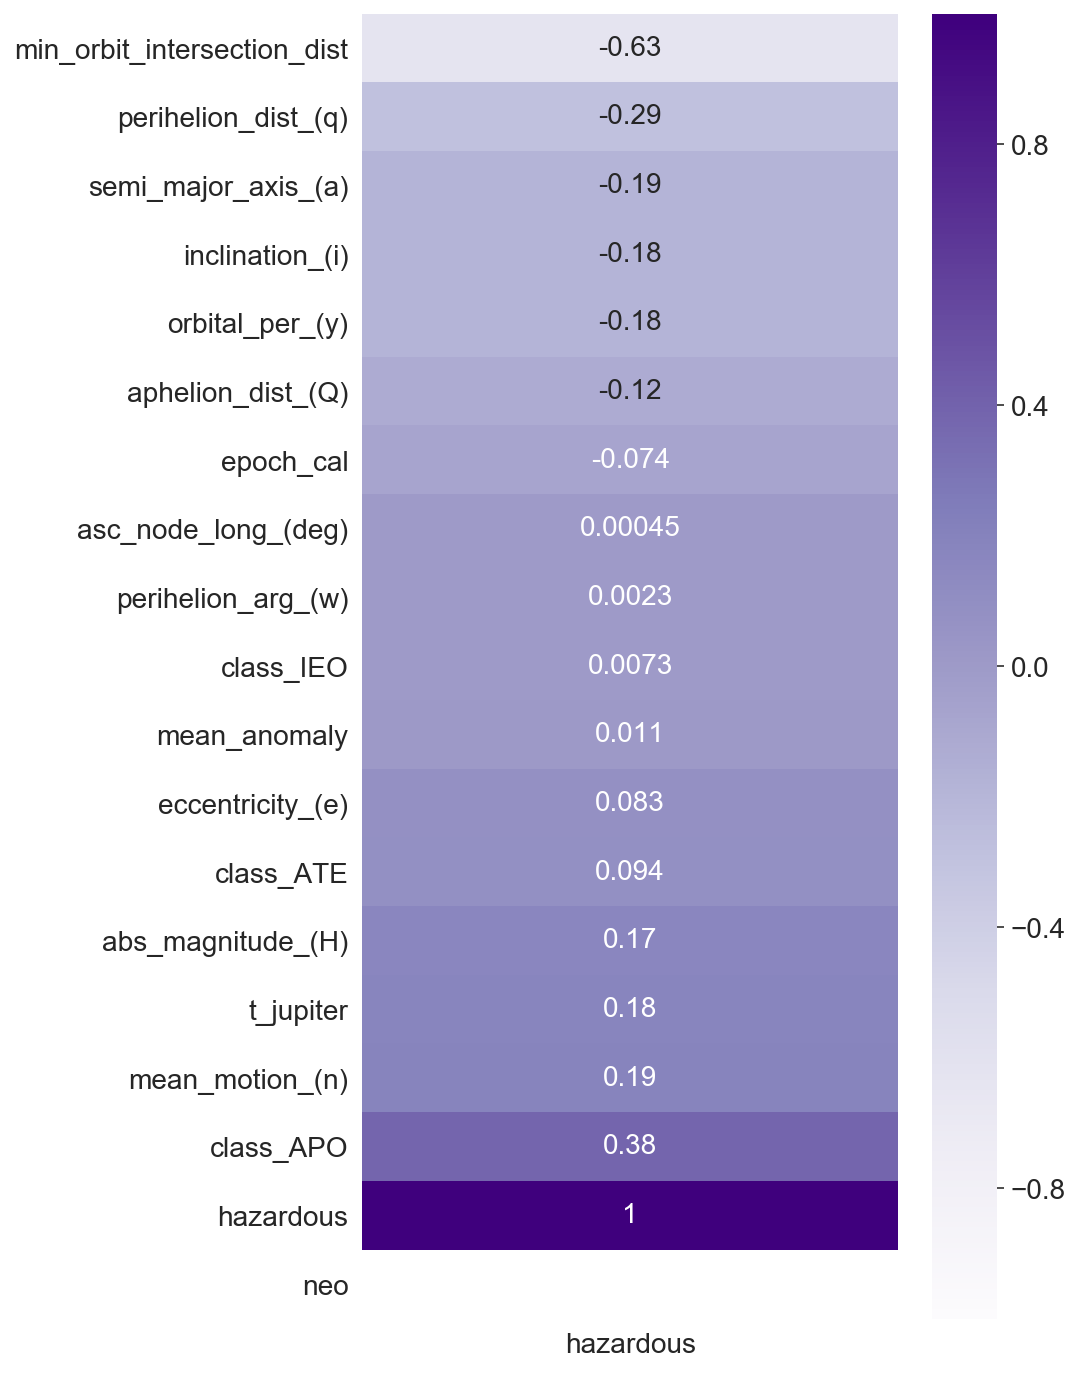

<Figure size 1080x648 with 0 Axes>

In [1027]:
corr = df.corr()[['hazardous']].sort_values('hazardous')

plt.figure(figsize = (6,12))
sns.heatmap(corr,
           vmin=-1,
           vmax=1,
           cmap='Purples',
           annot=True)

# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show();
plt.savefig('../images/hazardous_feature_corr.png');

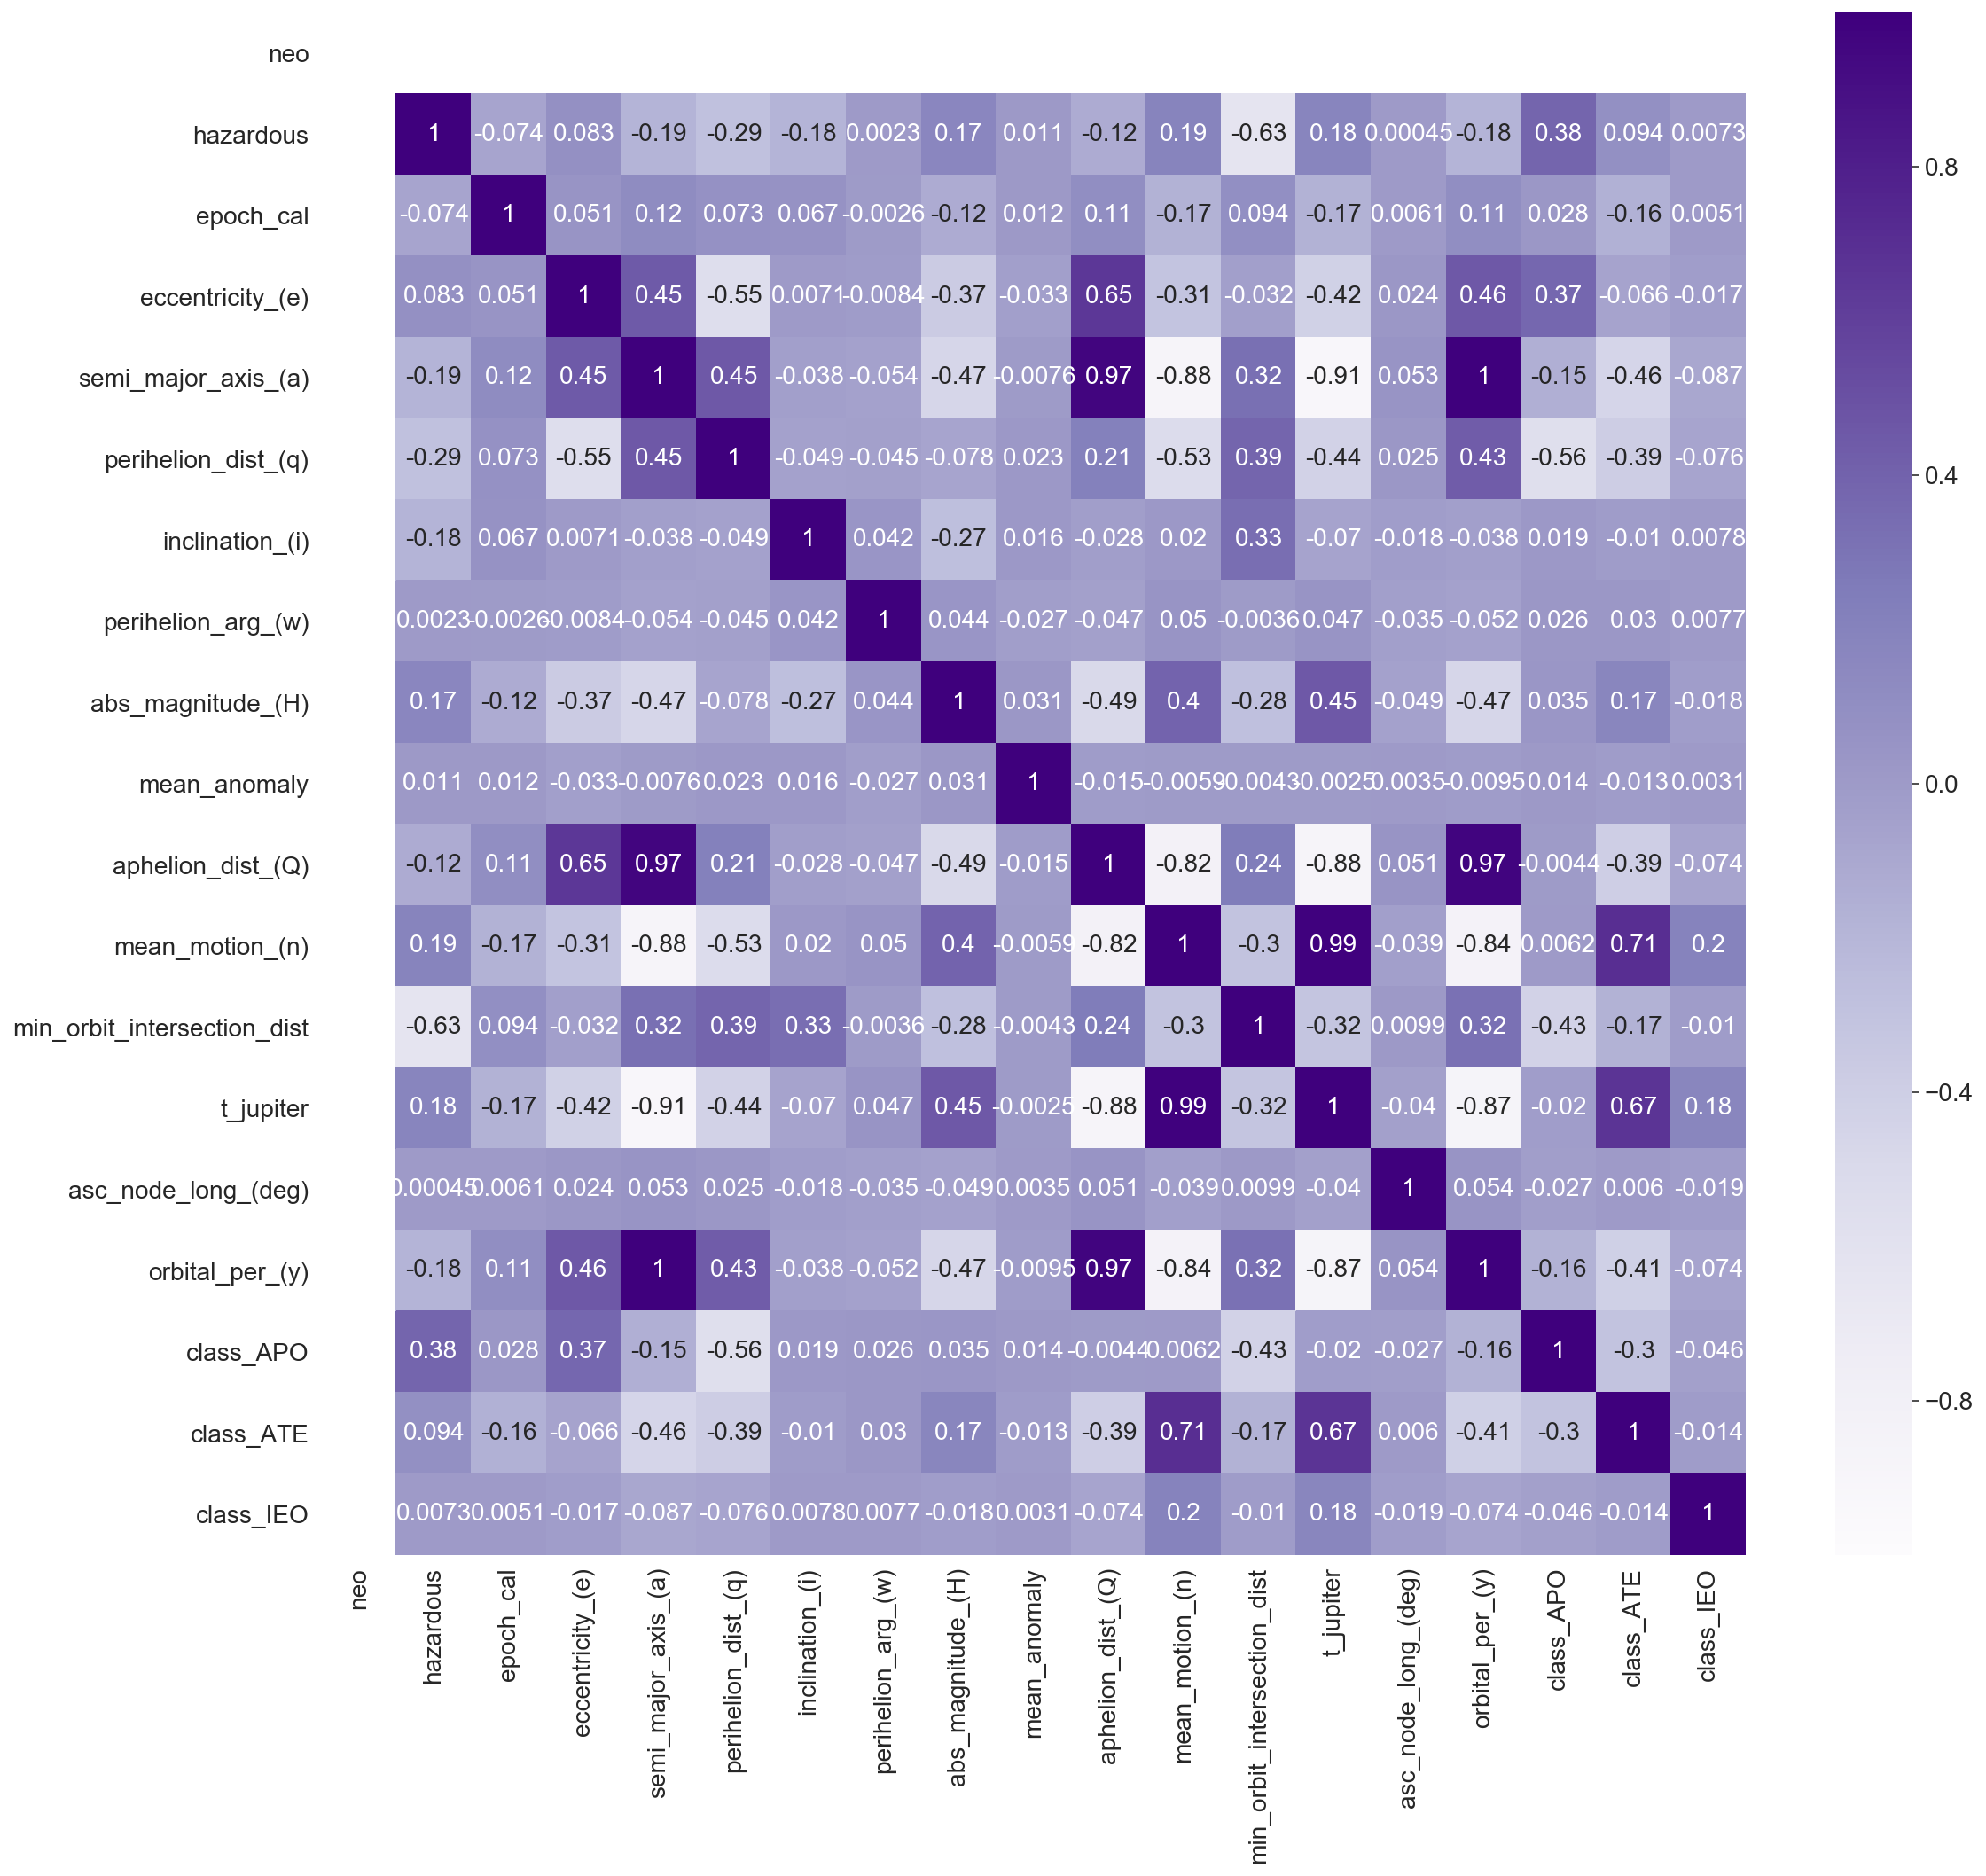

In [1028]:
plt.figure(figsize=(18,16))
sns.heatmap(df.corr(), vmin=-1, vmax=1, annot=True, cmap='Purples' );

# https://github.com/mwaskom/seaborn/issues/1773
# fix for mpl bug that cuts off top/bottom of seaborn viz
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update the ylim(bottom, top) values
plt.show();

In [1029]:
# Make copy of df to set first observed as index
df1 = df.copy()
df1.set_index('first_obs', inplace=True)

# Make copy of df to set last observed as index
df2 = df.copy()
df2.set_index('last_obs', inplace=True)

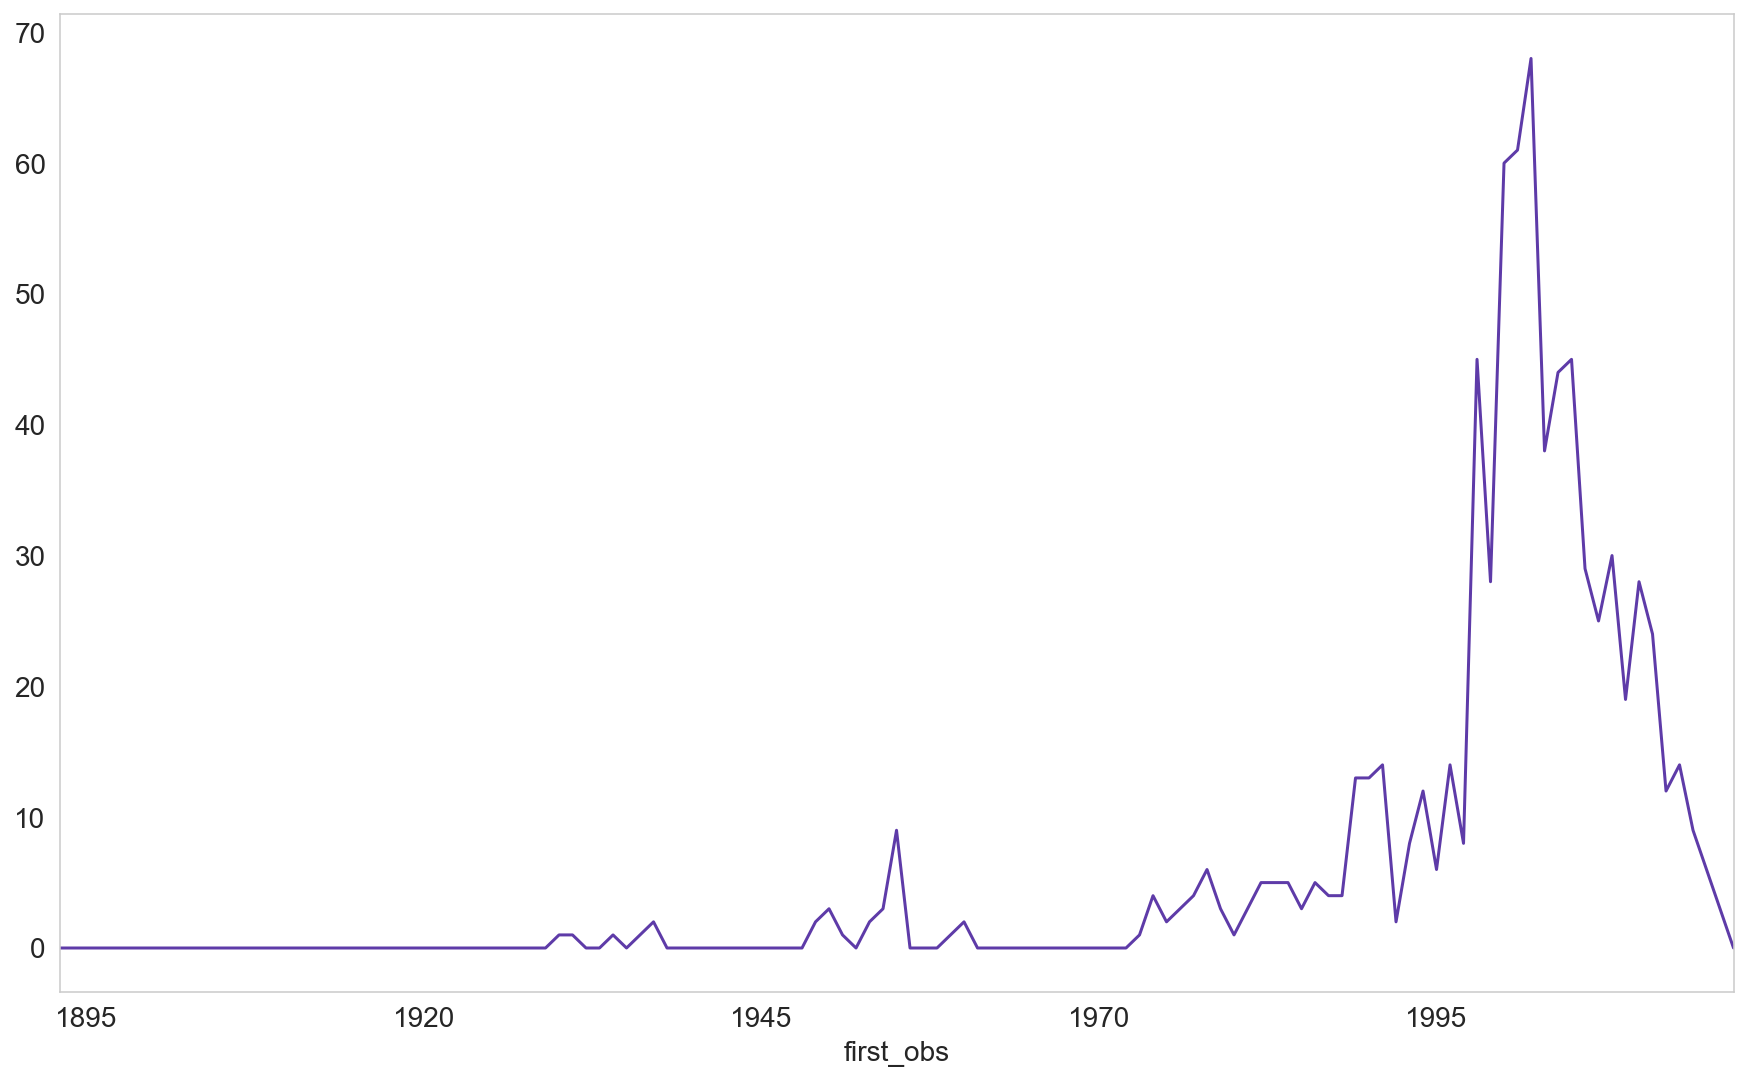

In [1032]:
df1['hazardous'].resample('Y').sum().plot(grid=False, color=c[2]);

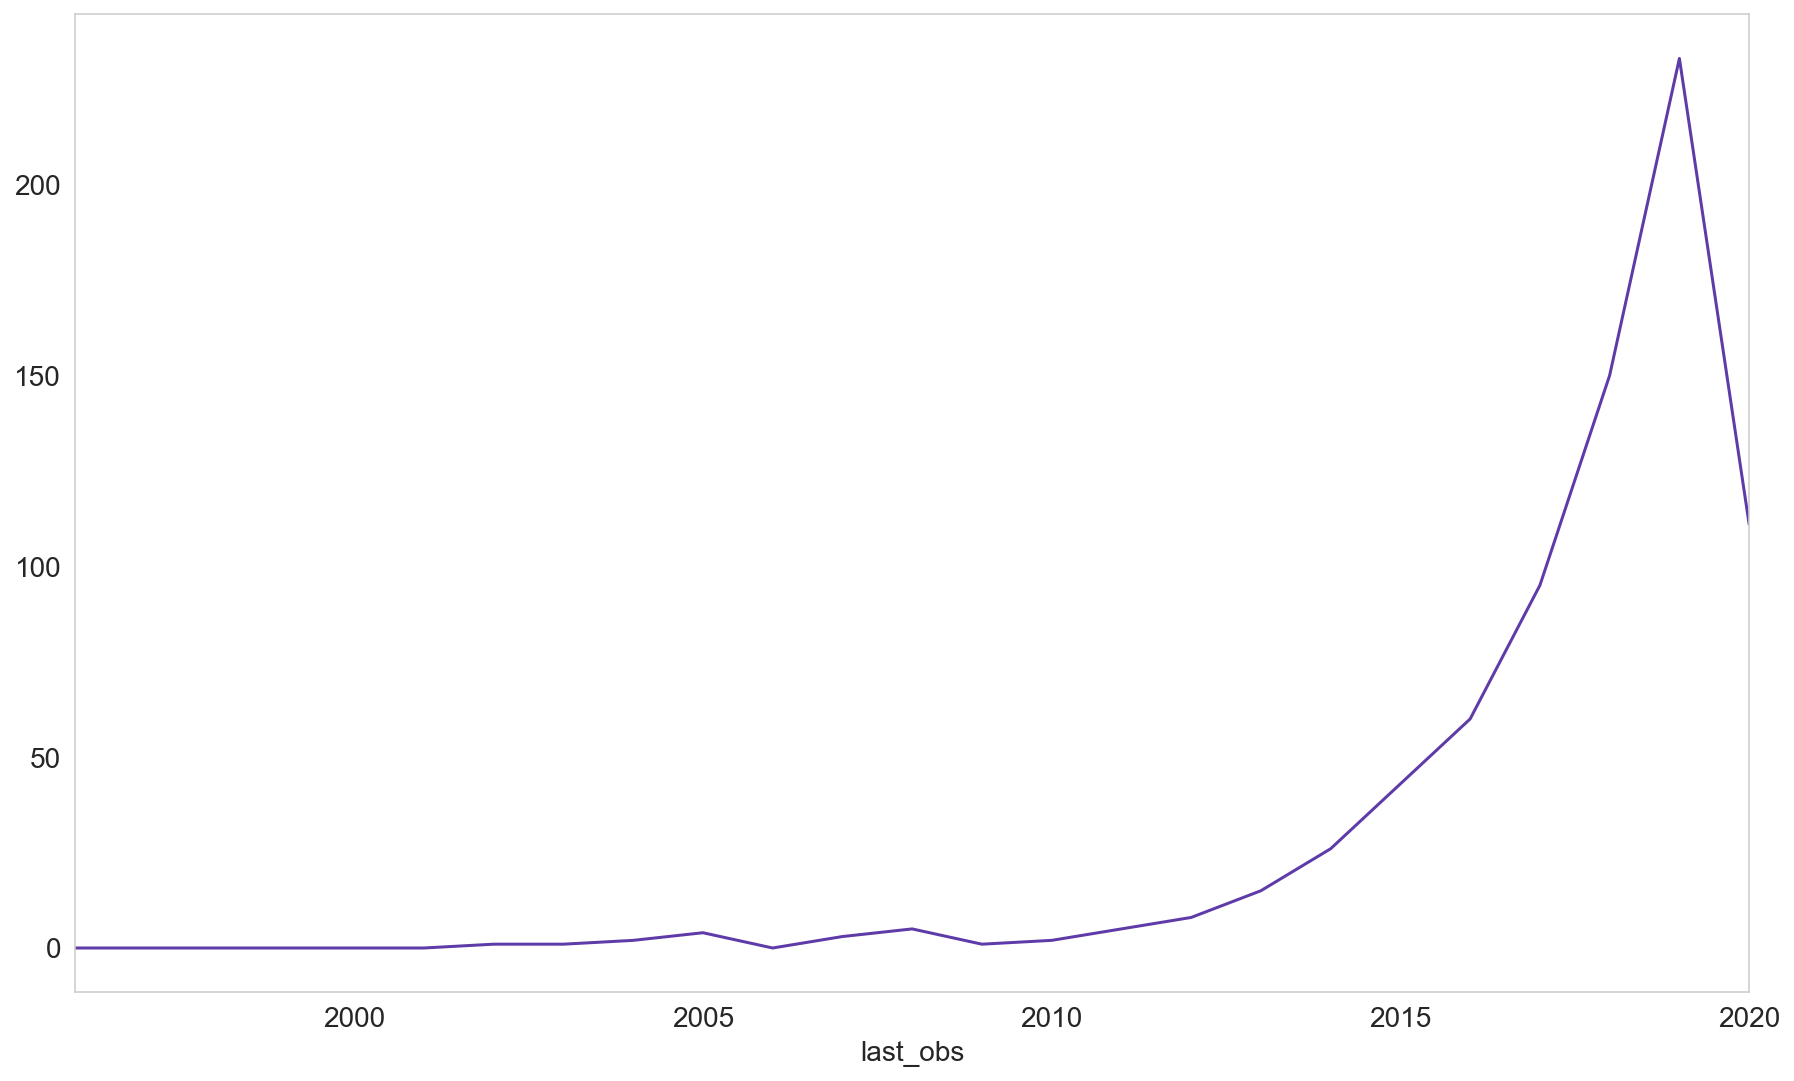

In [1033]:
df2['hazardous'].resample('Y').sum().plot(grid=False, color=c[2]);

In [1034]:
df1[['neo']].resample('Y').sum().describe()

,neo
count,125.000000
mean,23.336000
std,49.494207
min,0.000000
25%,0.000000
50%,1.000000
75%,21.000000
max,285.000000


In [1035]:
# labels = list(df1.index.year.values)
# len(labels)

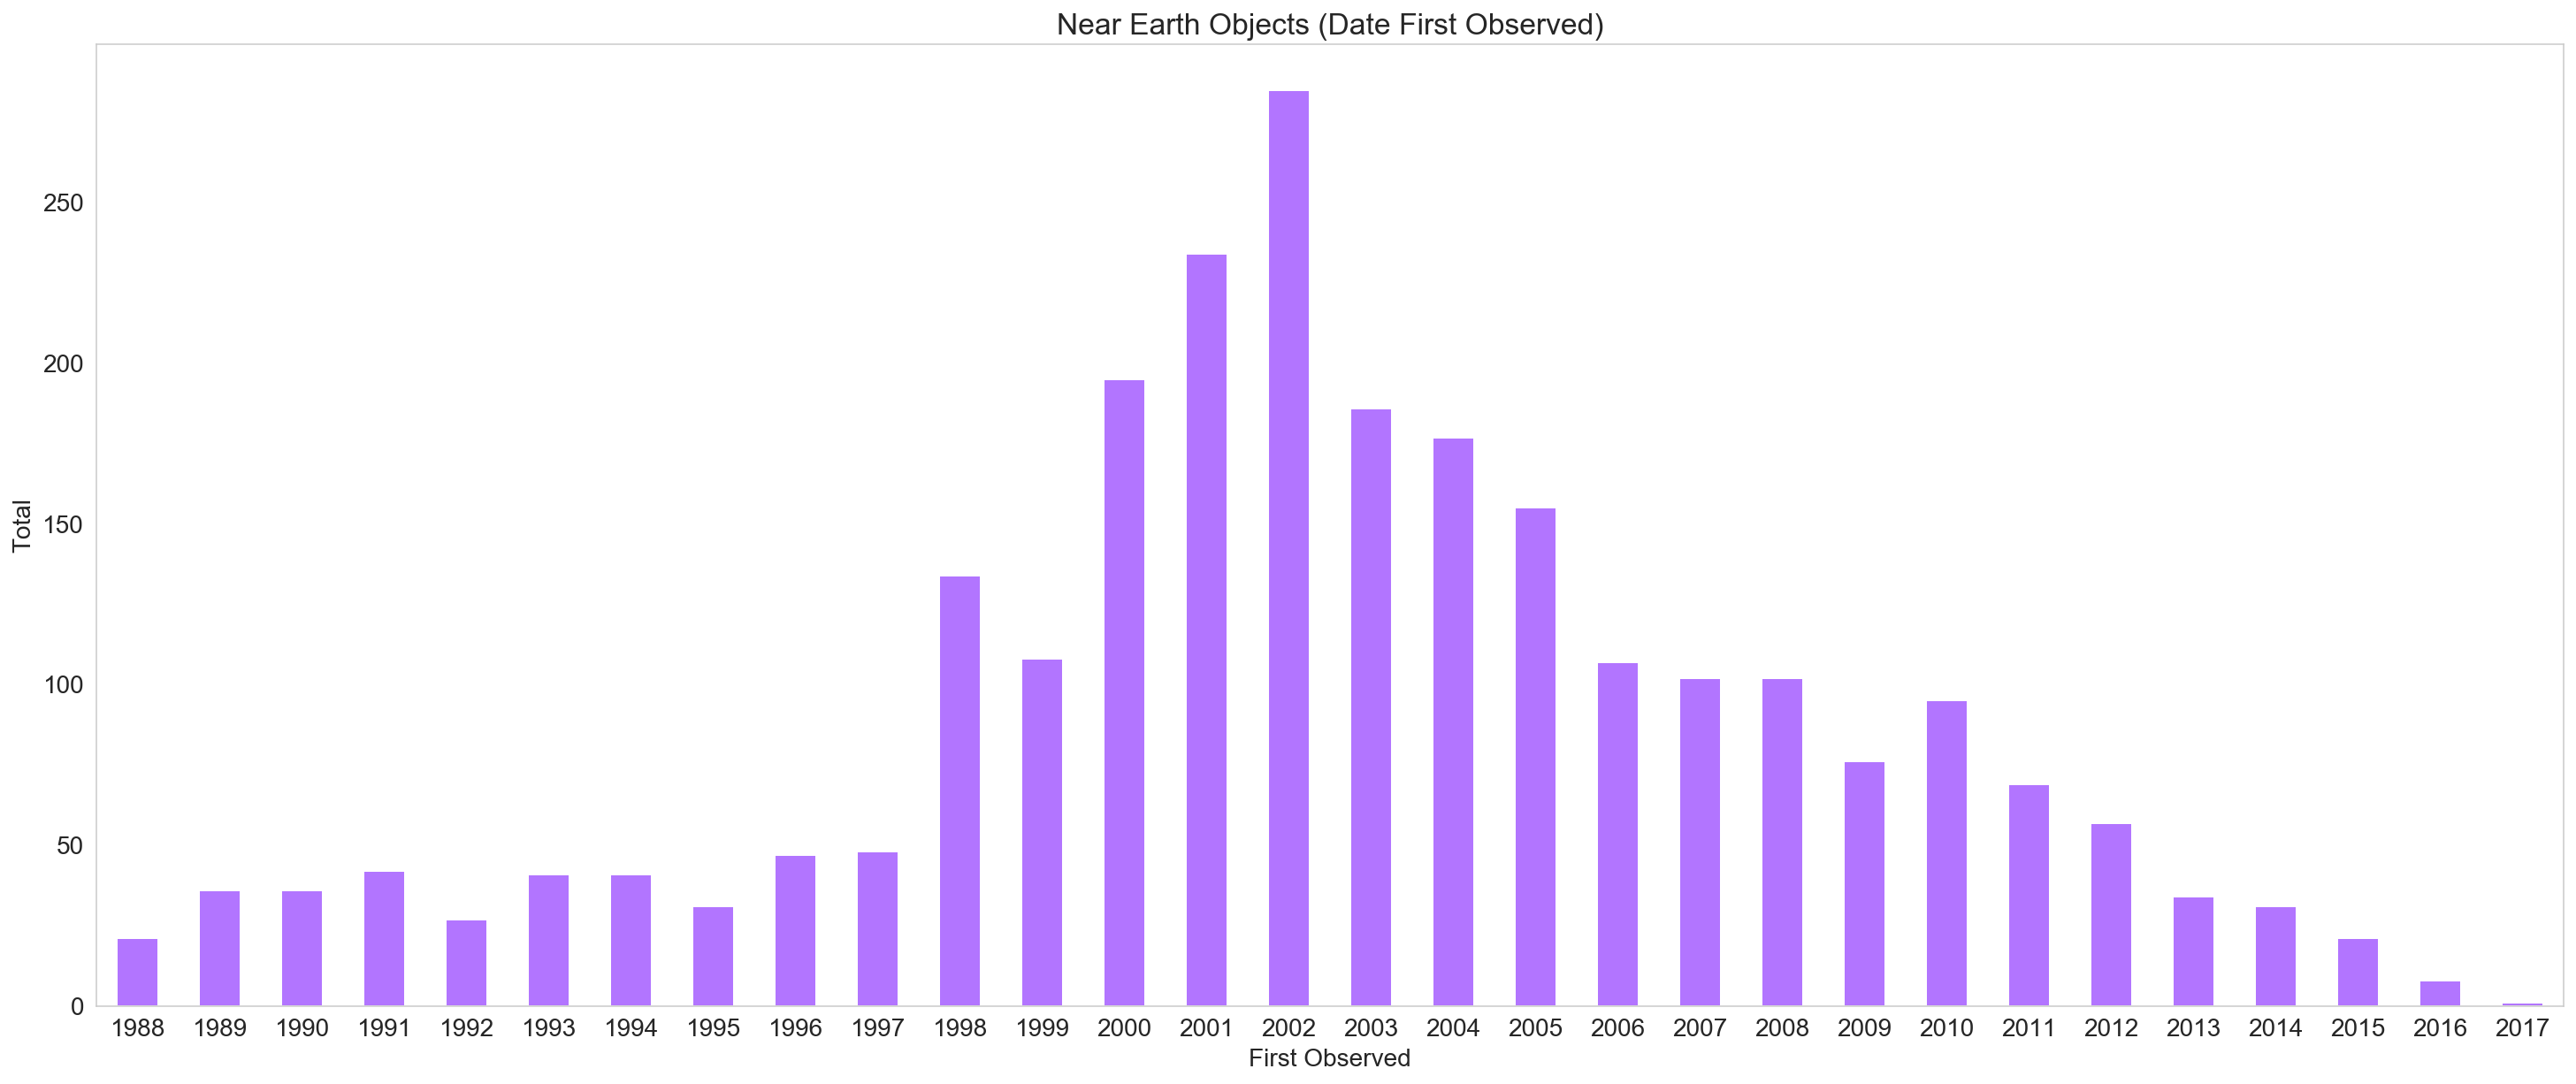

In [1036]:
labels1 = df1['neo'].sort_values().resample('Y').sum().tail(30).index.year.values

plt.figure(figsize=(25,10))
df1['neo'].sort_values().resample('Y').sum().tail(30).plot(kind='bar', grid=False, color=c[0])
plt.title('Near Earth Objects (Date First Observed)')
plt.ylabel('Total')
plt.xlabel('First Observed')
plt.xticks(ticks = np.arange(30), labels=labels1, rotation = 'horizontal');
plt.savefig('../images/NEO_first_obs.png');

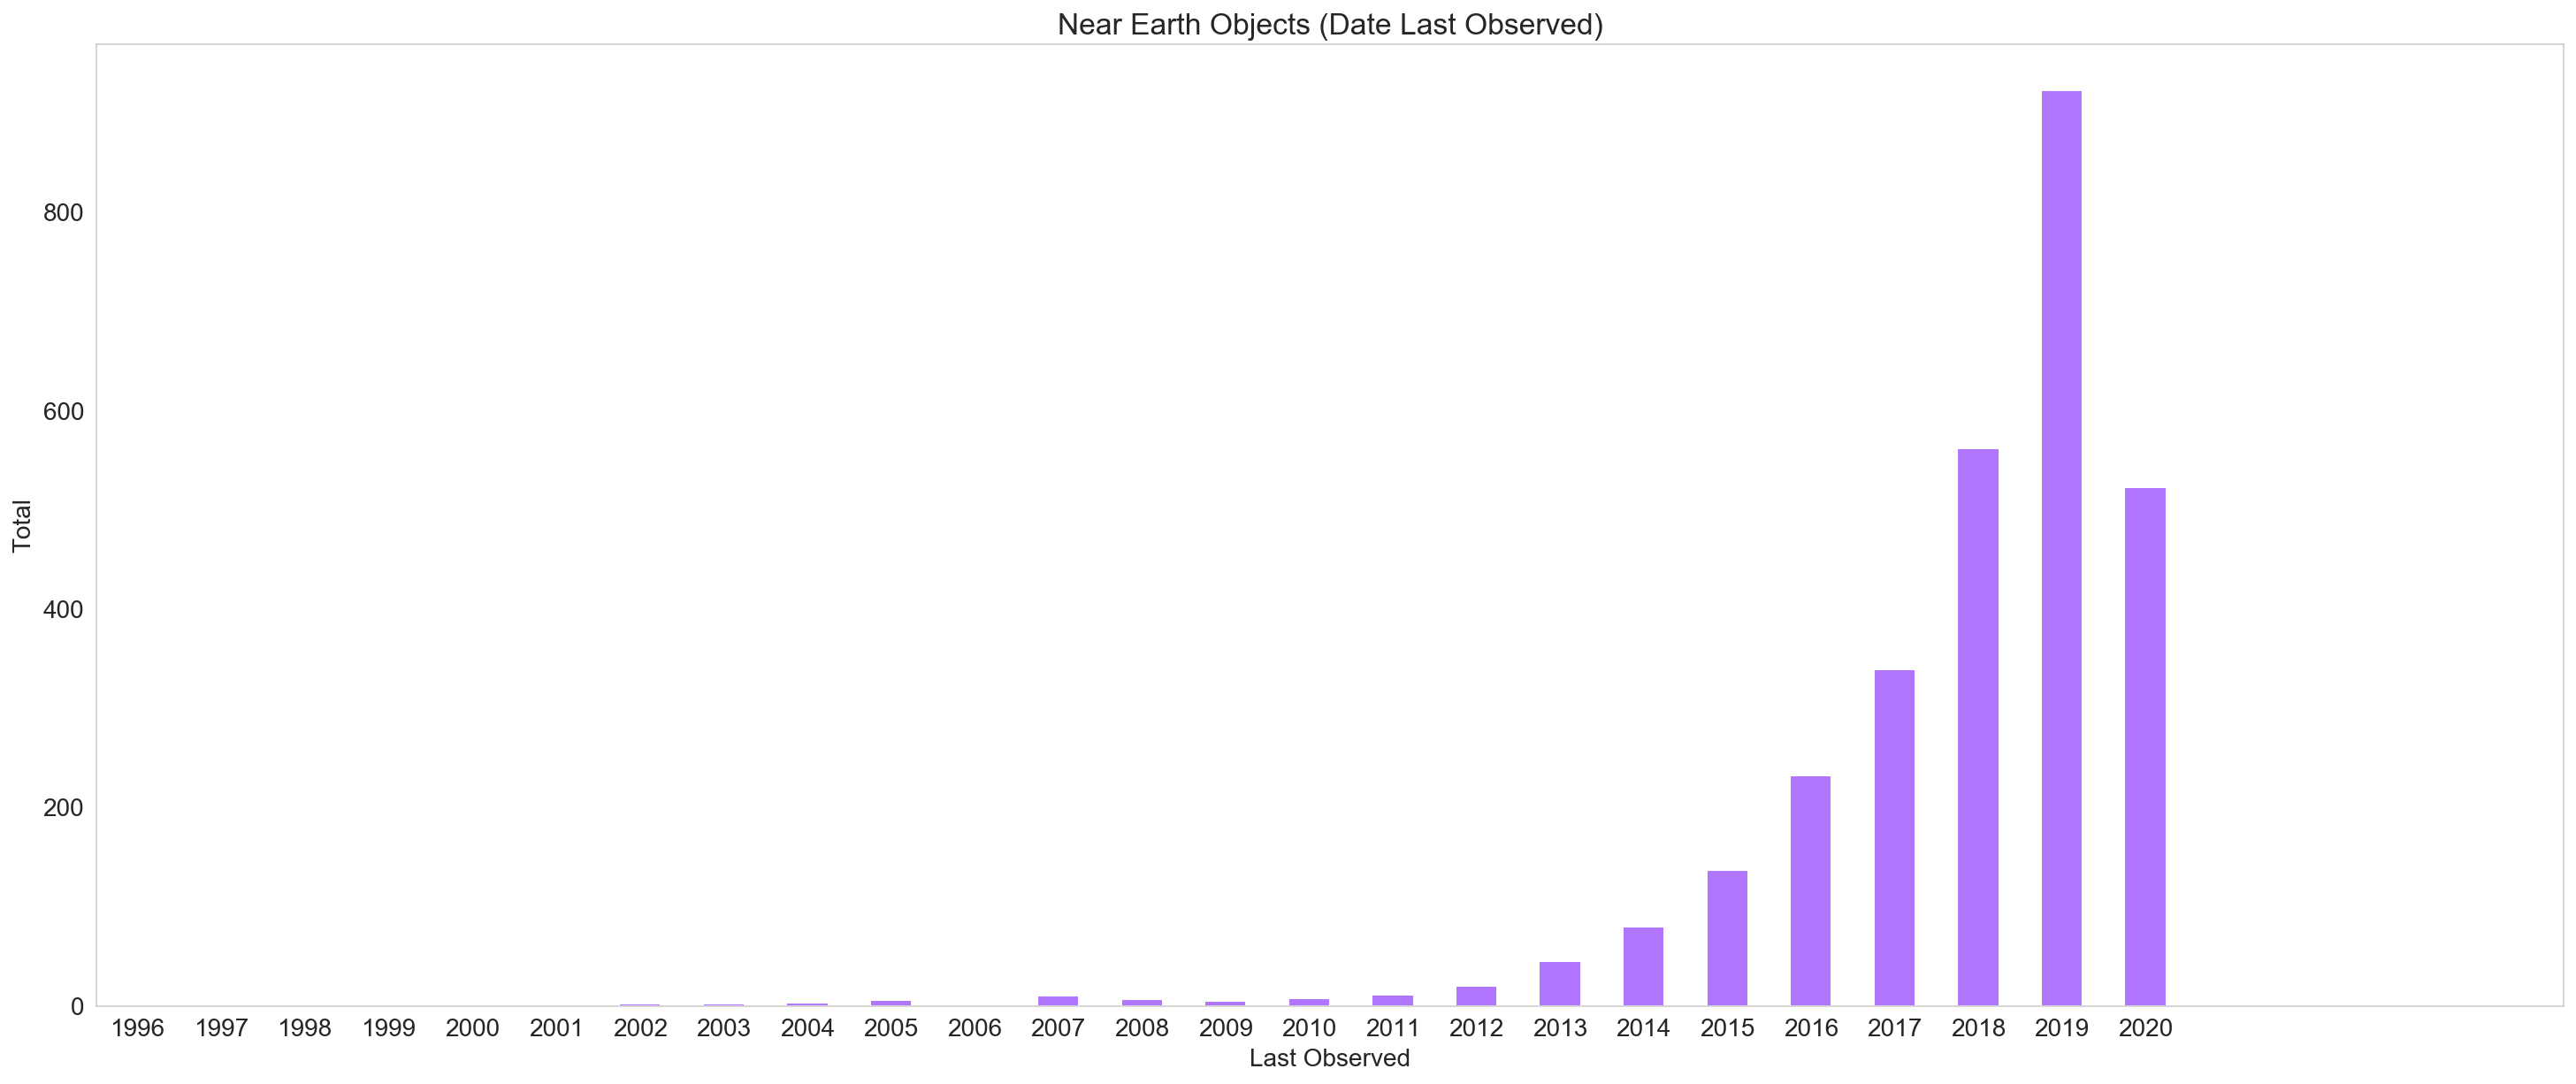

In [1037]:
labels2 = df2['neo'].resample('Y').sum().index.year.values

plt.figure(figsize=(25,10))
df2['neo'].resample('Y').sum().plot(kind='bar', grid=False, color=c[0])
plt.title('Near Earth Objects (Date Last Observed)')
plt.ylabel('Total')
plt.xlabel('Last Observed')
plt.xticks(ticks = np.arange(30), labels=labels2, rotation = 'horizontal');
plt.savefig('../images/NEO_last_obs.png');

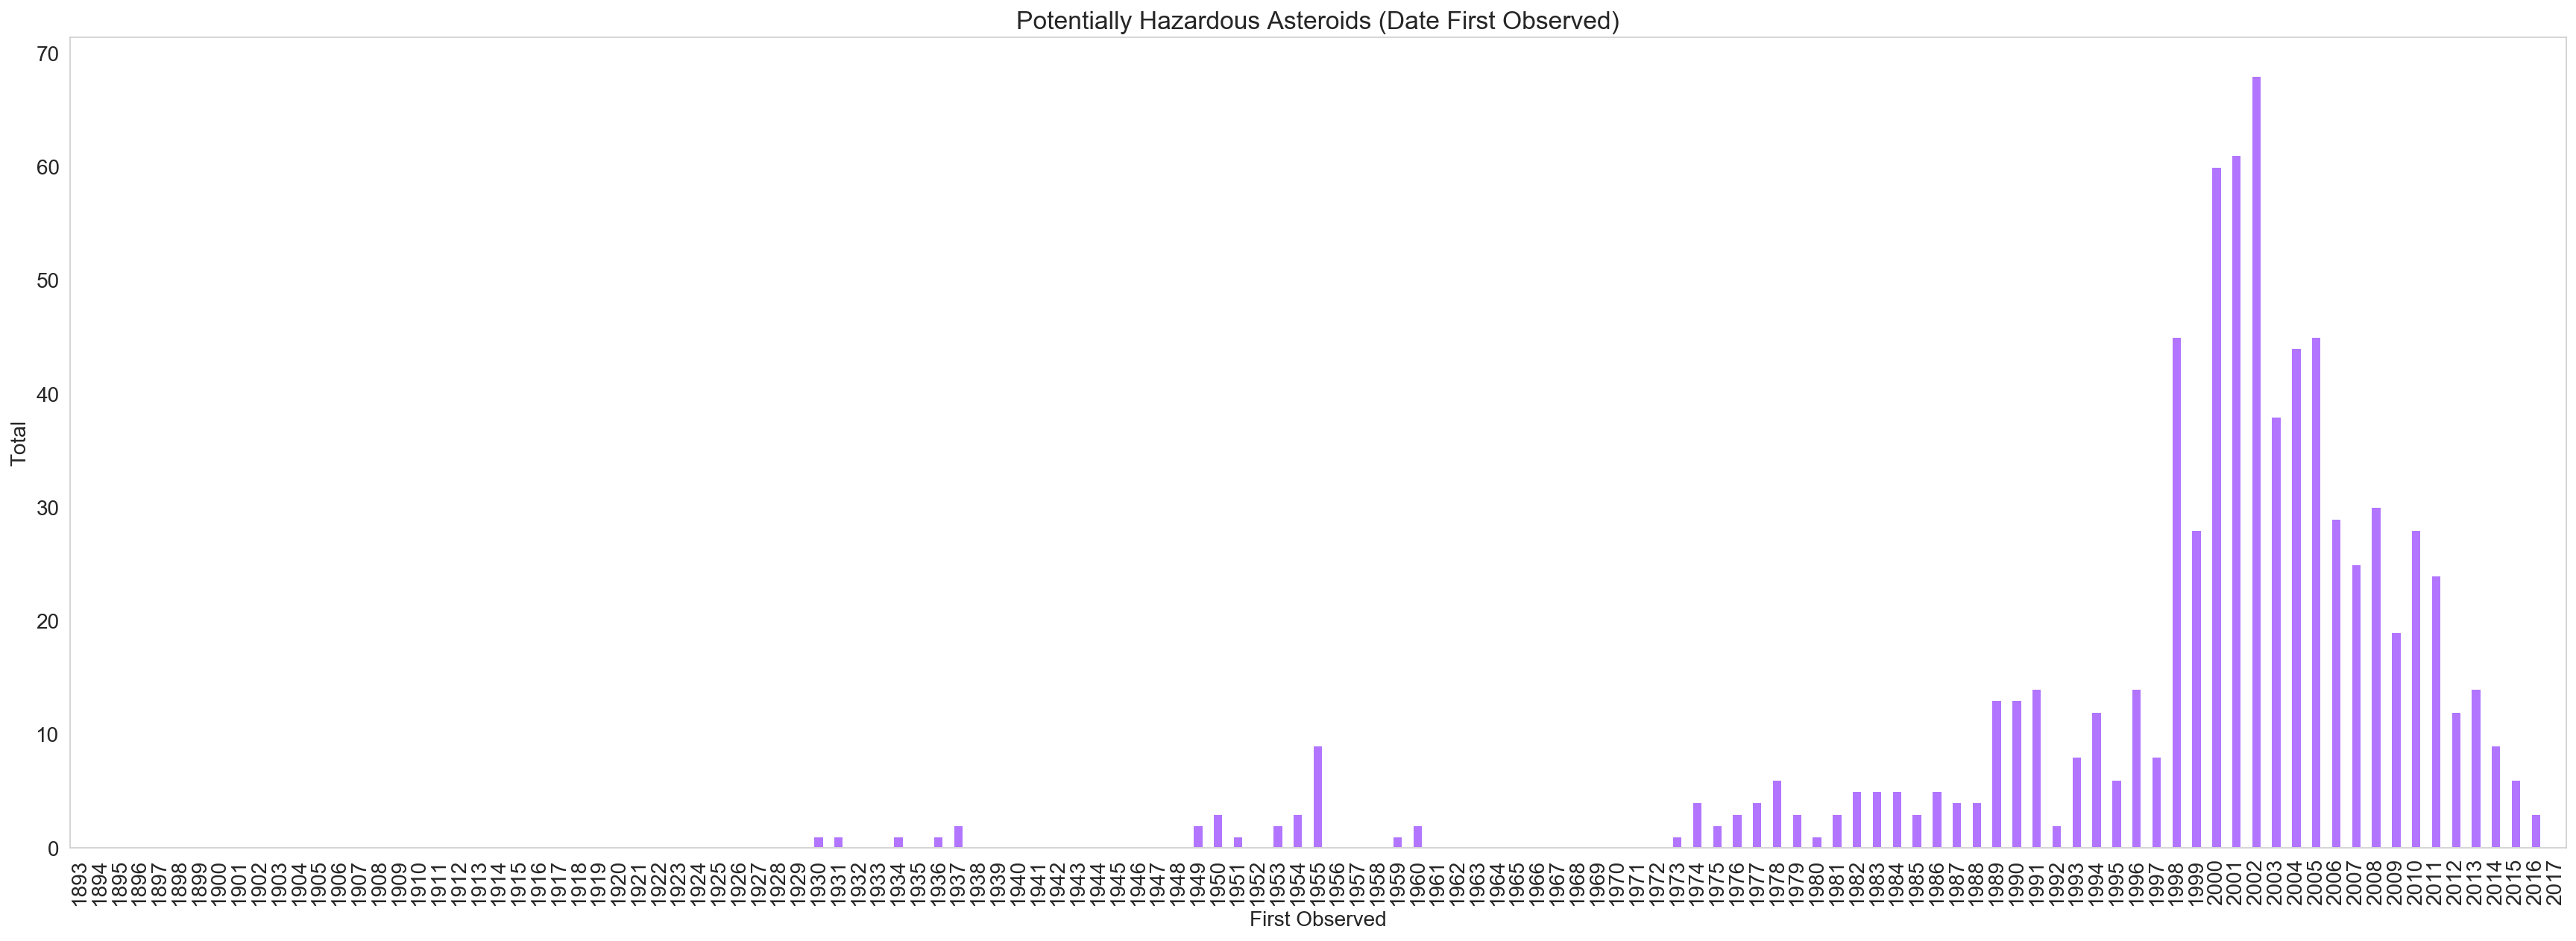

In [1038]:
haz_labels = df1['hazardous'].resample('Y').sum().index.year.values

plt.figure(figsize=(30,10))
df1['hazardous'].resample('Y').sum().plot(kind='bar', grid=False, color=c[0])
plt.title('Potentially Hazardous Asteroids (Date First Observed)')
plt.ylabel('Total')
plt.xlabel('First Observed')
plt.xticks(ticks = np.arange(125), labels=haz_labels);
plt.savefig('../images/PHA_first_obs.png');

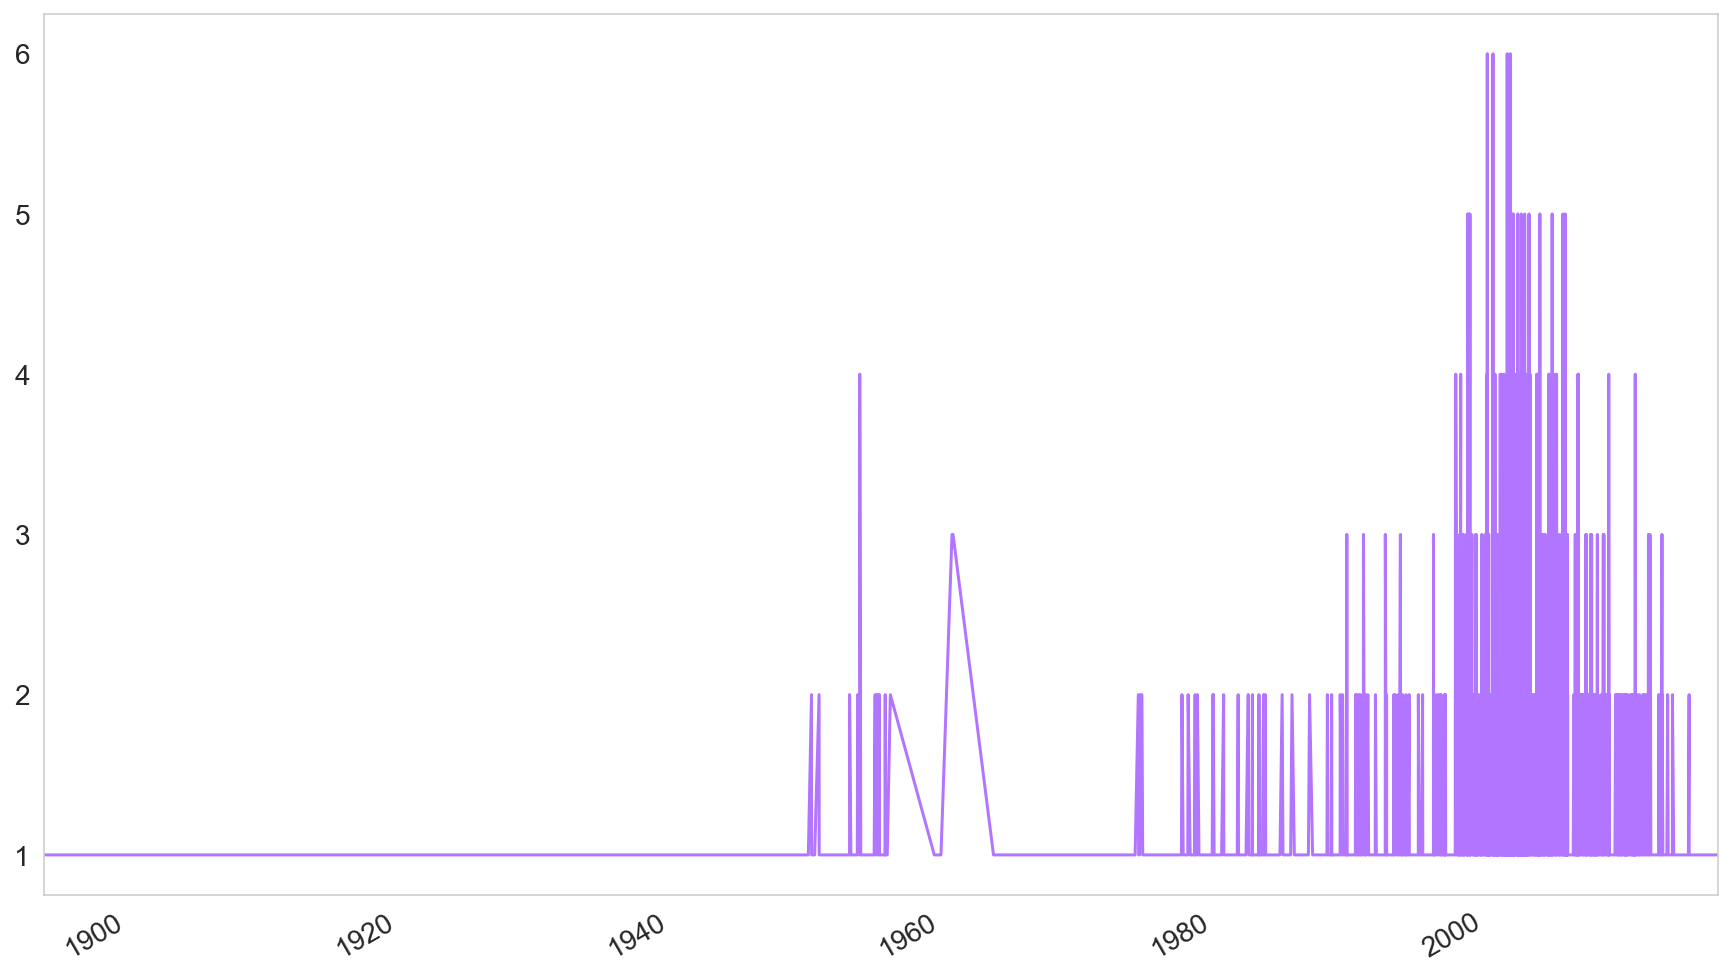

In [1039]:
df.sort_values(by='hazardous')['first_obs'].value_counts().plot(grid=False, color=c[0]);


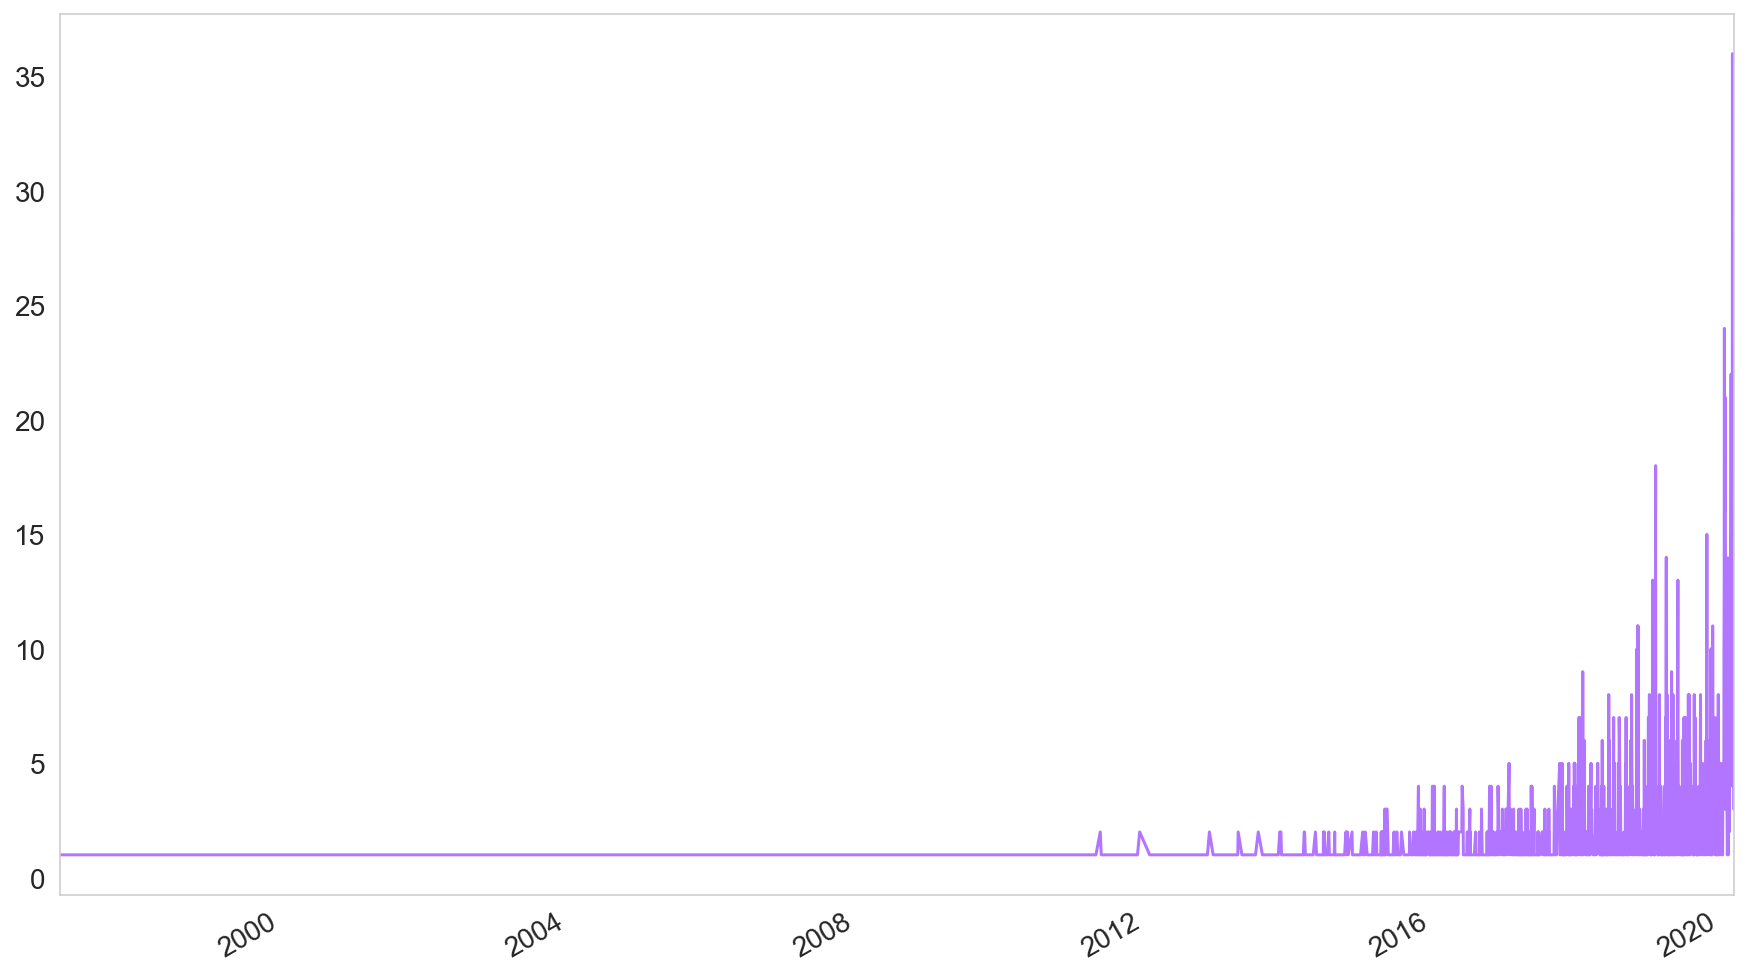

In [1040]:
df.sort_values(by='hazardous')['last_obs'].value_counts().plot(grid=False, color=c[0]);


### Orbital Elements



![orbitalelements](../images/orbitalelements.png)
[source](http://www.columbia.edu/~my2317/asteroidproject.html)

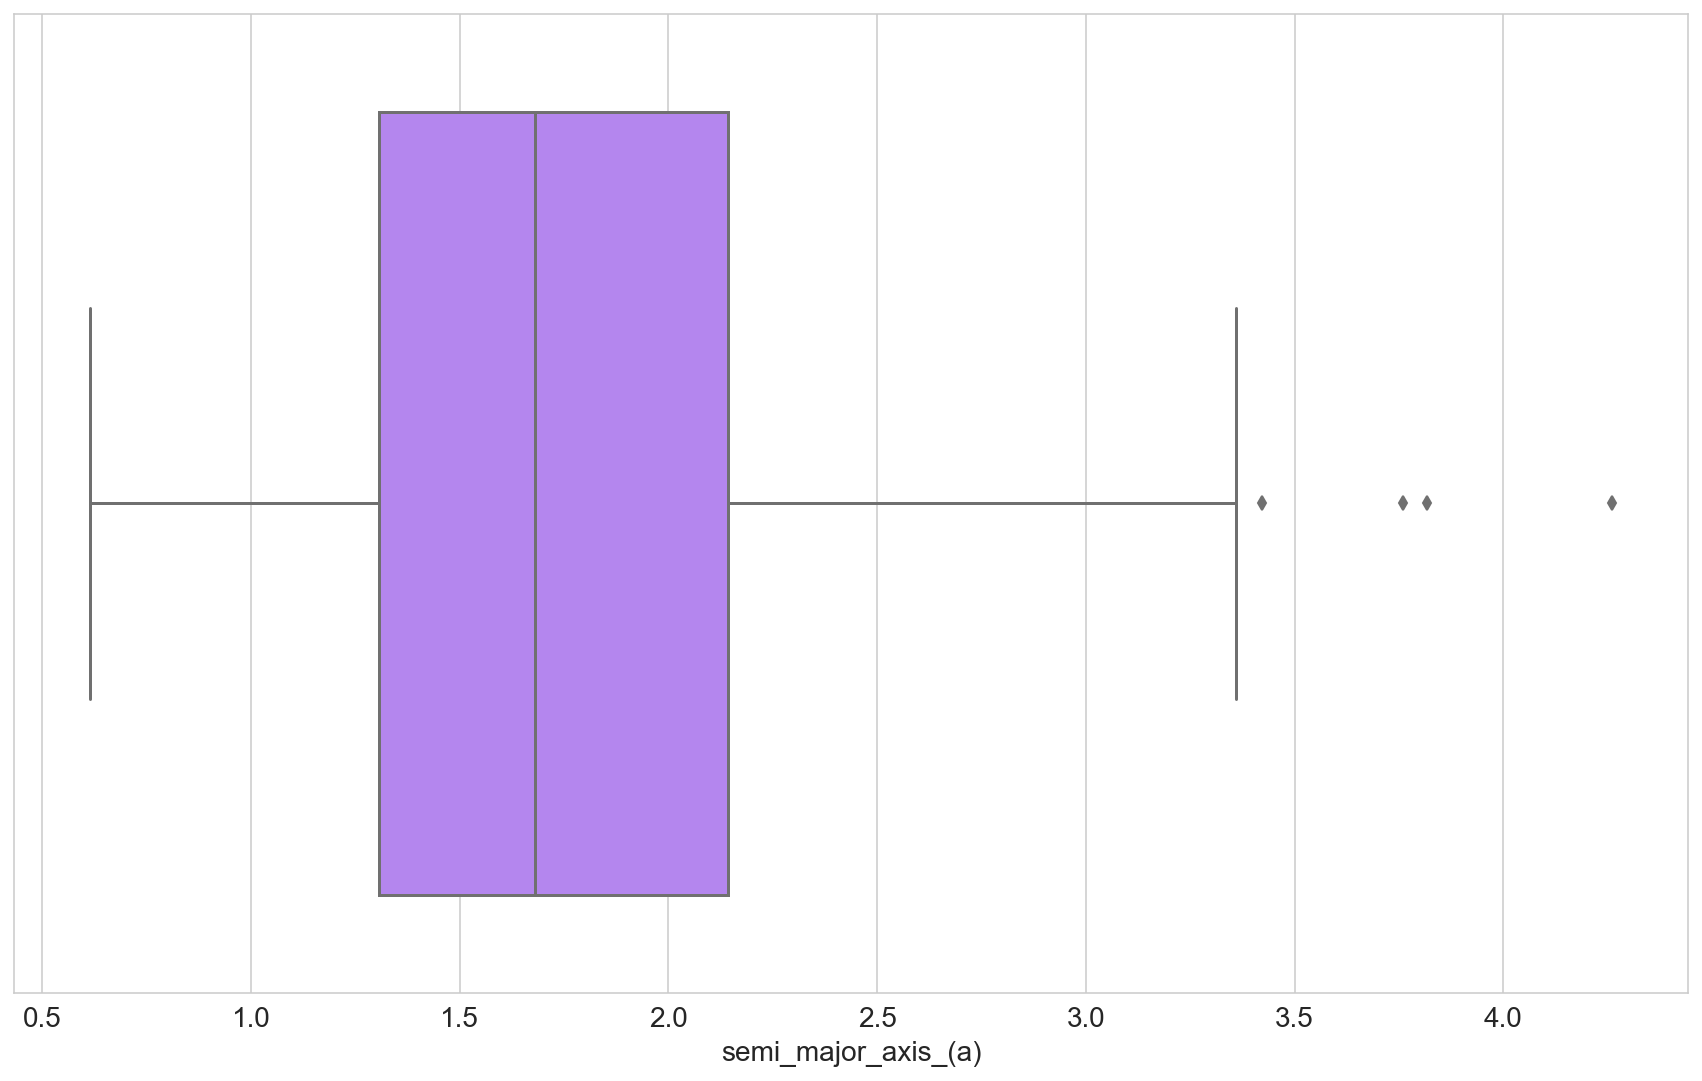

In [1041]:
sns.boxplot(x=df['semi_major_axis_(a)'], data=df, color=c[0])

### Finding Standard Gravitational Parameter
---

**Formula:**  
$\mu = \frac{4\pi^2a^3}{T^2}$


Defines a function that takes the inputs $a$ (the semi-major axis) and $T$ (the orbital period in years) to find the standard gravitational parameter. 

In [1042]:
import math
# Function to calculate standard gravitational parameter in order 
# to find the relative velocity of an asteroid given the semi-major axis and the orbital period
# result will be in au/yr

def stand_grav_param(a, T, df):
    stand_grav_param_list = []
    for i in a:
        for t in T:
            stand_grav_param = (4 * (math.pi**2) * (i**3)) / (t**2)
        stand_grav_param_list.append(stand_grav_param)
    df['stand_grav_param'] = stand_grav_param_list
    return df['stand_grav_param']

In [1043]:
stand_grav_param(df['semi_major_axis_(a)'], df['orbital_per_(y)'], df)

0       13.866566
1       82.182090
2       67.719856
3       84.647180
4       31.638696
          ...    
2912    15.126618
2913     4.966050
2914     4.611972
2915    43.686169
2916    39.476926
Name: stand_grav_param, Length: 2917, dtype: float64

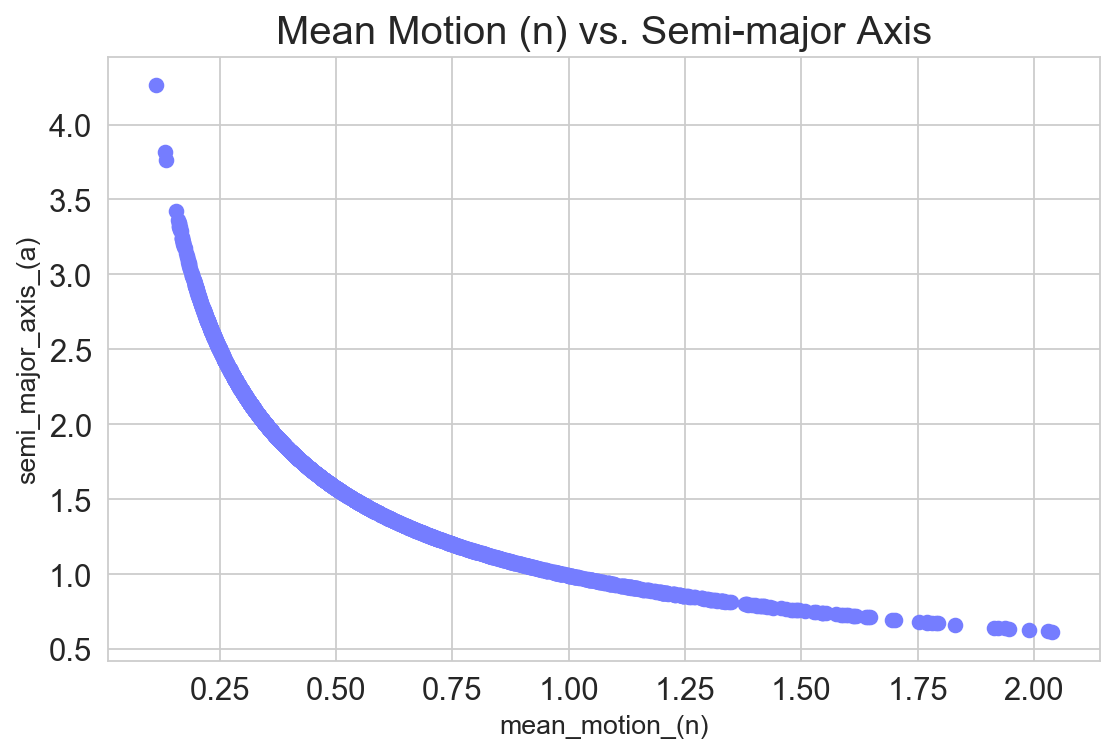

In [1044]:
plot_scatterplot(df, ['mean_motion_(n)', 'semi_major_axis_(a)'], 'Mean Motion (n) vs. Semi-major Axis', 'mean_motion_(n)', 'semi_major_axis_(a)')

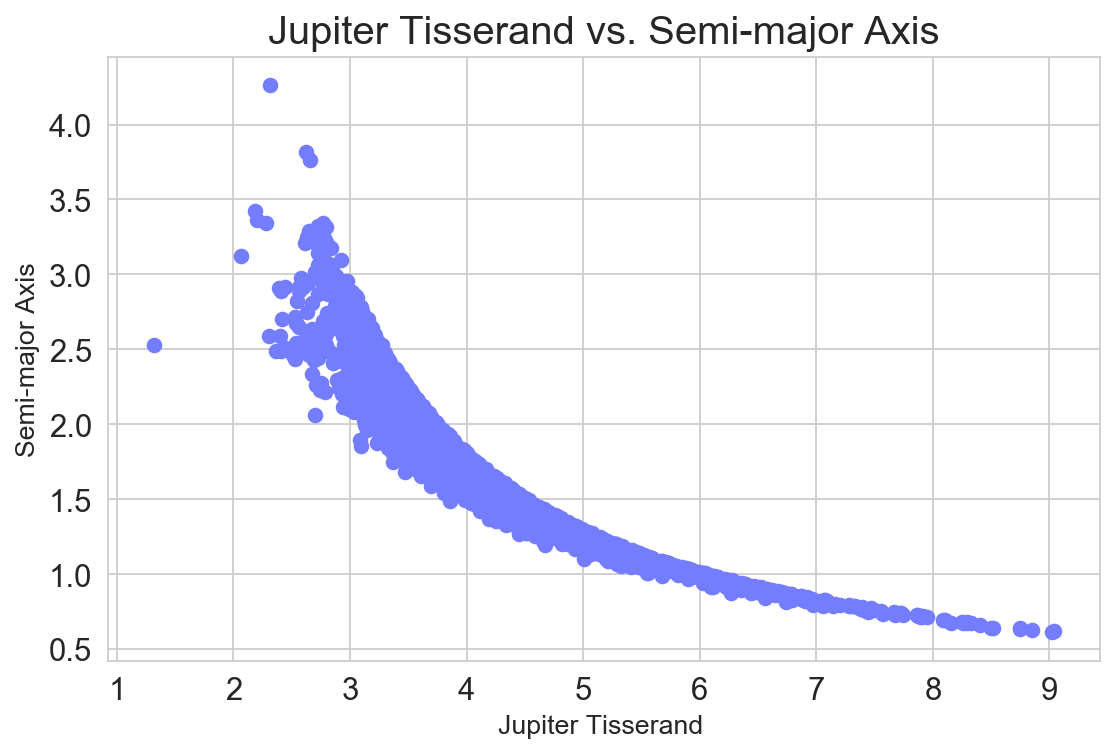

In [1045]:
plot_scatterplot(df, ['t_jupiter', 'semi_major_axis_(a)'], 'Jupiter Tisserand vs. Semi-major Axis', 'Jupiter Tisserand ', 'Semi-major Axis');

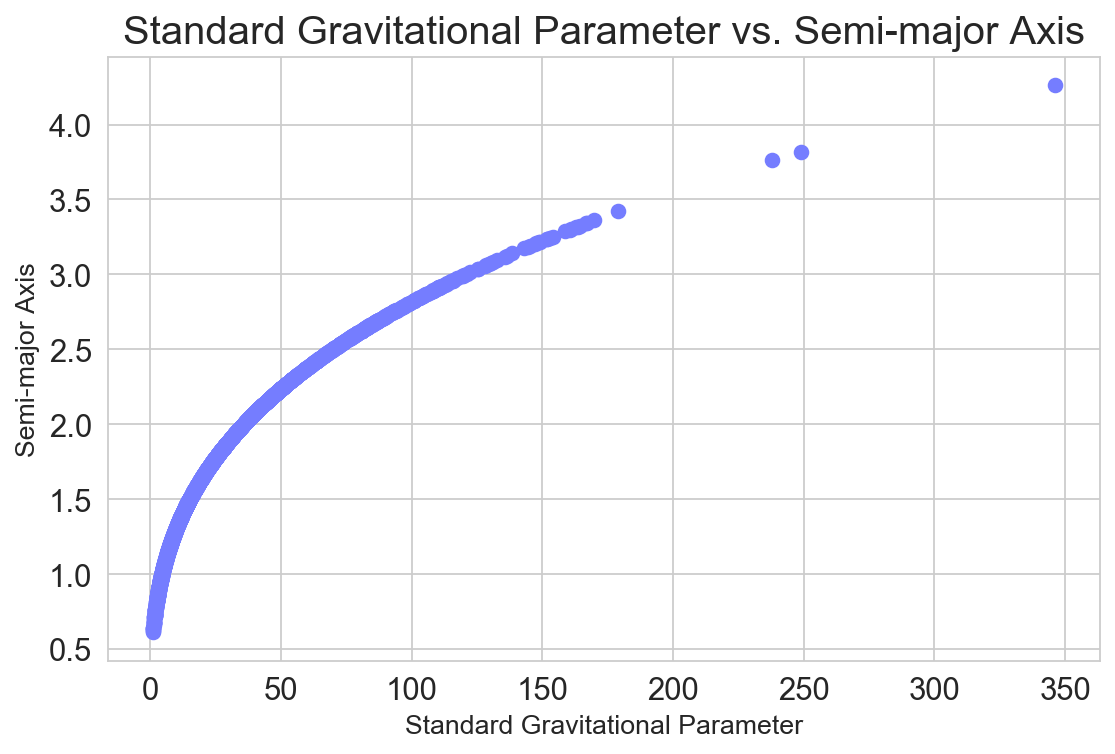

In [1046]:
plot_scatterplot(df, ['stand_grav_param', 'semi_major_axis_(a)'], 'Standard Gravitational Parameter vs. Semi-major Axis', 'Standard Gravitational Parameter', 'Semi-major Axis');




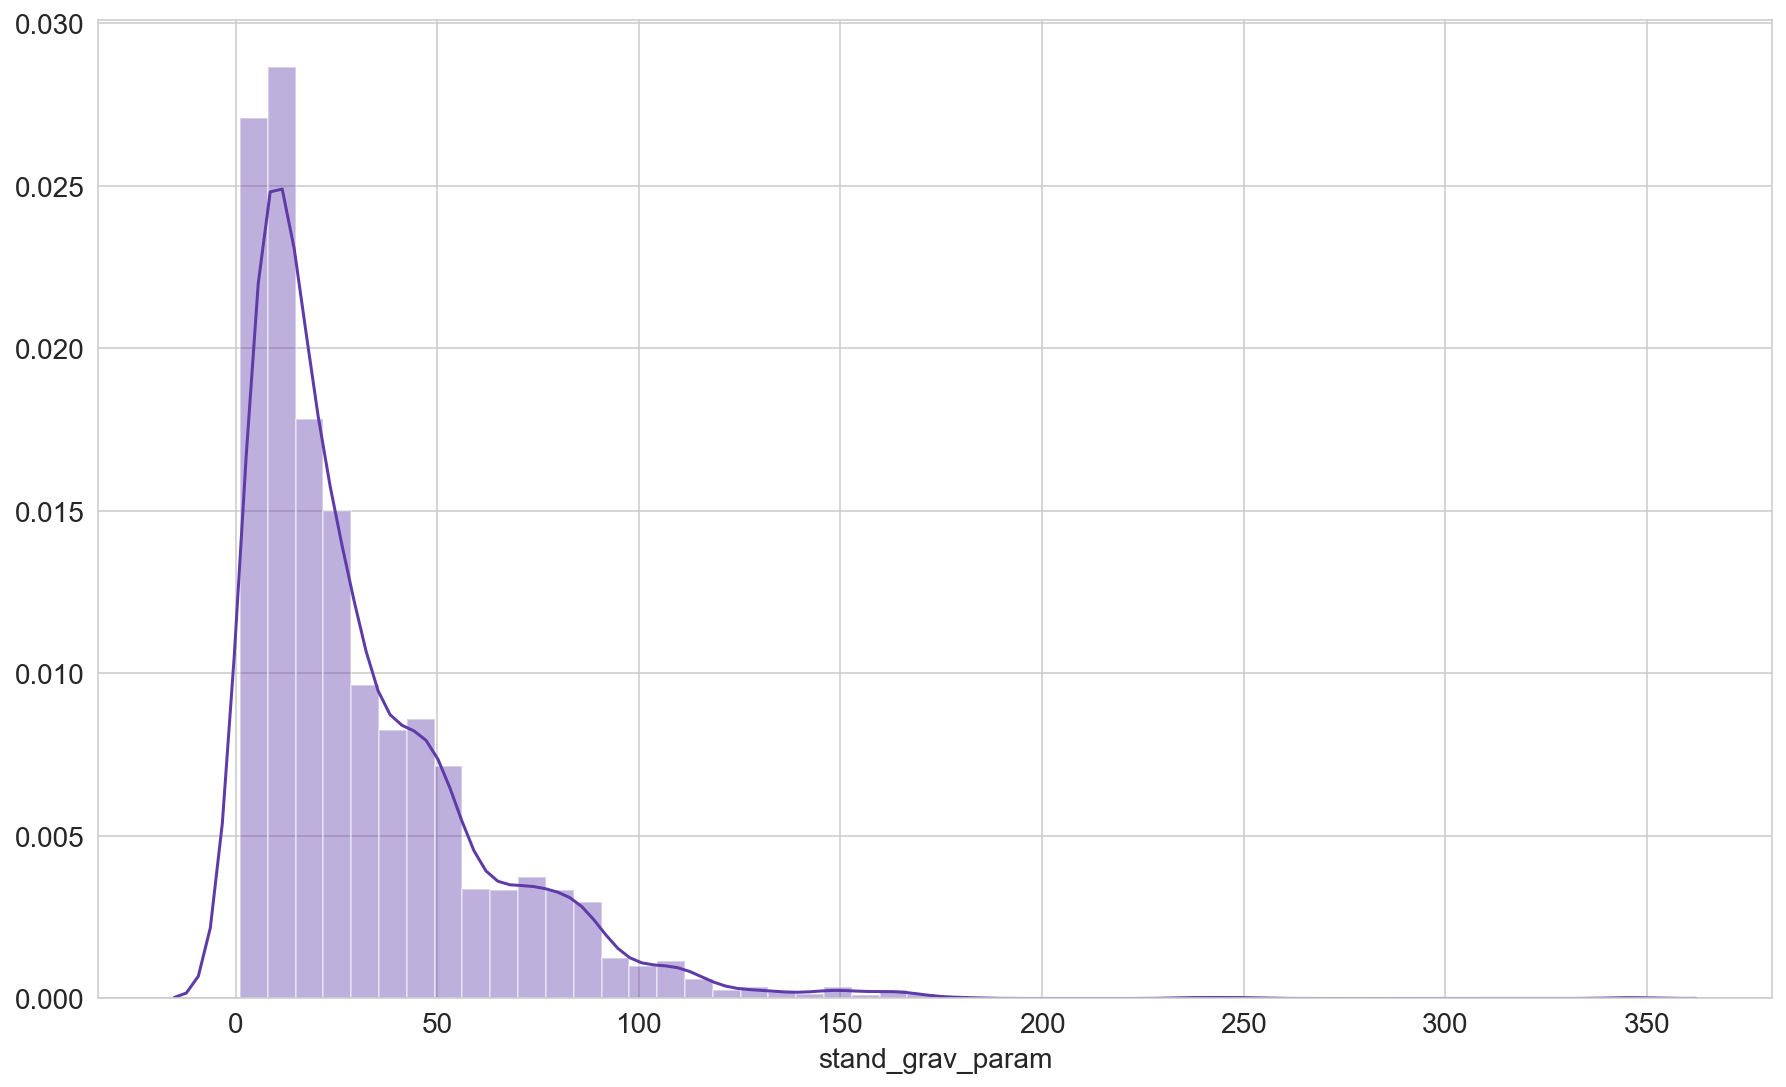

In [1047]:
# View a quick distribution
sns.distplot(df['stand_grav_param'], color=c[2])

### Finding Instantaneous Orbit Velocity

---
**Formula:**  
$v$ = $\mu\sqrt{{\frac{2}{r}}-{\frac{1}{a}}}$


Create function that will take the $r$ (the orbital distance from the sun), $a$ (the semi-major axis), and `stand_grav_param` (the standard gravitational parameter calculated above).

In [1048]:
# Create a function to calculate the instantaneous velocity
# Result in AU/year

def calc_velocity(r, a, stand_grav_param):
    velocity = (stand_grav_param * ((2/r) - (1/a)))**.5
    return velocity

In [1049]:
# Apply the function to find the velocity given the semimajor axis and the farthest distance from the Sun
df['rel_velocity_Q'] = calc_velocity(df['aphelion_dist_(Q)'], df['semi_major_axis_(a)'], df['stand_grav_param'])

# Apply the function to find the velocity given the semimajor axis and the closest distance from the Sun
df['rel_velocity_q'] = calc_velocity(df['perihelion_dist_(q)'], df['semi_major_axis_(a)'], df['stand_grav_param'])

# Current units AU/yr
# Convert to km/sec
df['rel_velocity_Q'] = df['rel_velocity_Q'] * 4.74372
df['rel_velocity_q'] = df['rel_velocity_q'] * 4.74372

In [1050]:
df.head()

,neo,hazardous,epoch_cal,eccentricity_(e),semi_major_axis_(a),perihelion_dist_(q),inclination_(i),perihelion_arg_(w),abs_magnitude_(H),mean_anomaly,...,asc_node_long_(deg),orbital_per_(y),first_obs,last_obs,class_APO,class_ATE,class_IEO,stand_grav_param,rel_velocity_Q,rel_velocity_q
0,1,0,20200531.0,0.222951,1.458046,1.132973,10.830543,178.882294,10.4,271.071732,...,304.299327,1.760617,1893-10-29,2019-02-13,0,0,0,13.866566,11.661046,18.352633
1,1,0,20200531.0,0.546558,2.638602,1.196452,11.567485,156.176338,15.4,140.273422,...,183.866950,4.286167,1911-10-04,2020-02-27,0,0,0,82.182090,14.335015,48.892609
2,1,0,20200531.0,0.570332,2.473737,1.062886,9.393854,350.495585,13.8,294.579157,...,110.434218,3.890796,1918-02-03,2019-08-27,0,0,0,67.719856,12.982886,47.449251
3,1,0,20200531.0,0.533046,2.664725,1.244303,26.677643,132.364631,9.4,4.817745,...,215.546826,4.349974,1924-10-23,2019-08-17,0,0,0,84.647180,14.755655,48.443972
4,1,0,20200531.0,0.435285,1.919498,1.083970,11.876536,26.694797,17.7,38.522409,...,171.326998,2.659437,1932-03-12,2020-01-24,0,0,0,31.638696,12.080367,30.703567


Compares the distribution between the relative orbital velocity from the **aphelion distance** (the farthest distance to the sun) and the **perihelion distance** (the closest distance to the sun).


![orbitalelements](../images/orbit_ellipse1.gif)
[source](https://calgary.rasc.ca/orbits.htm)

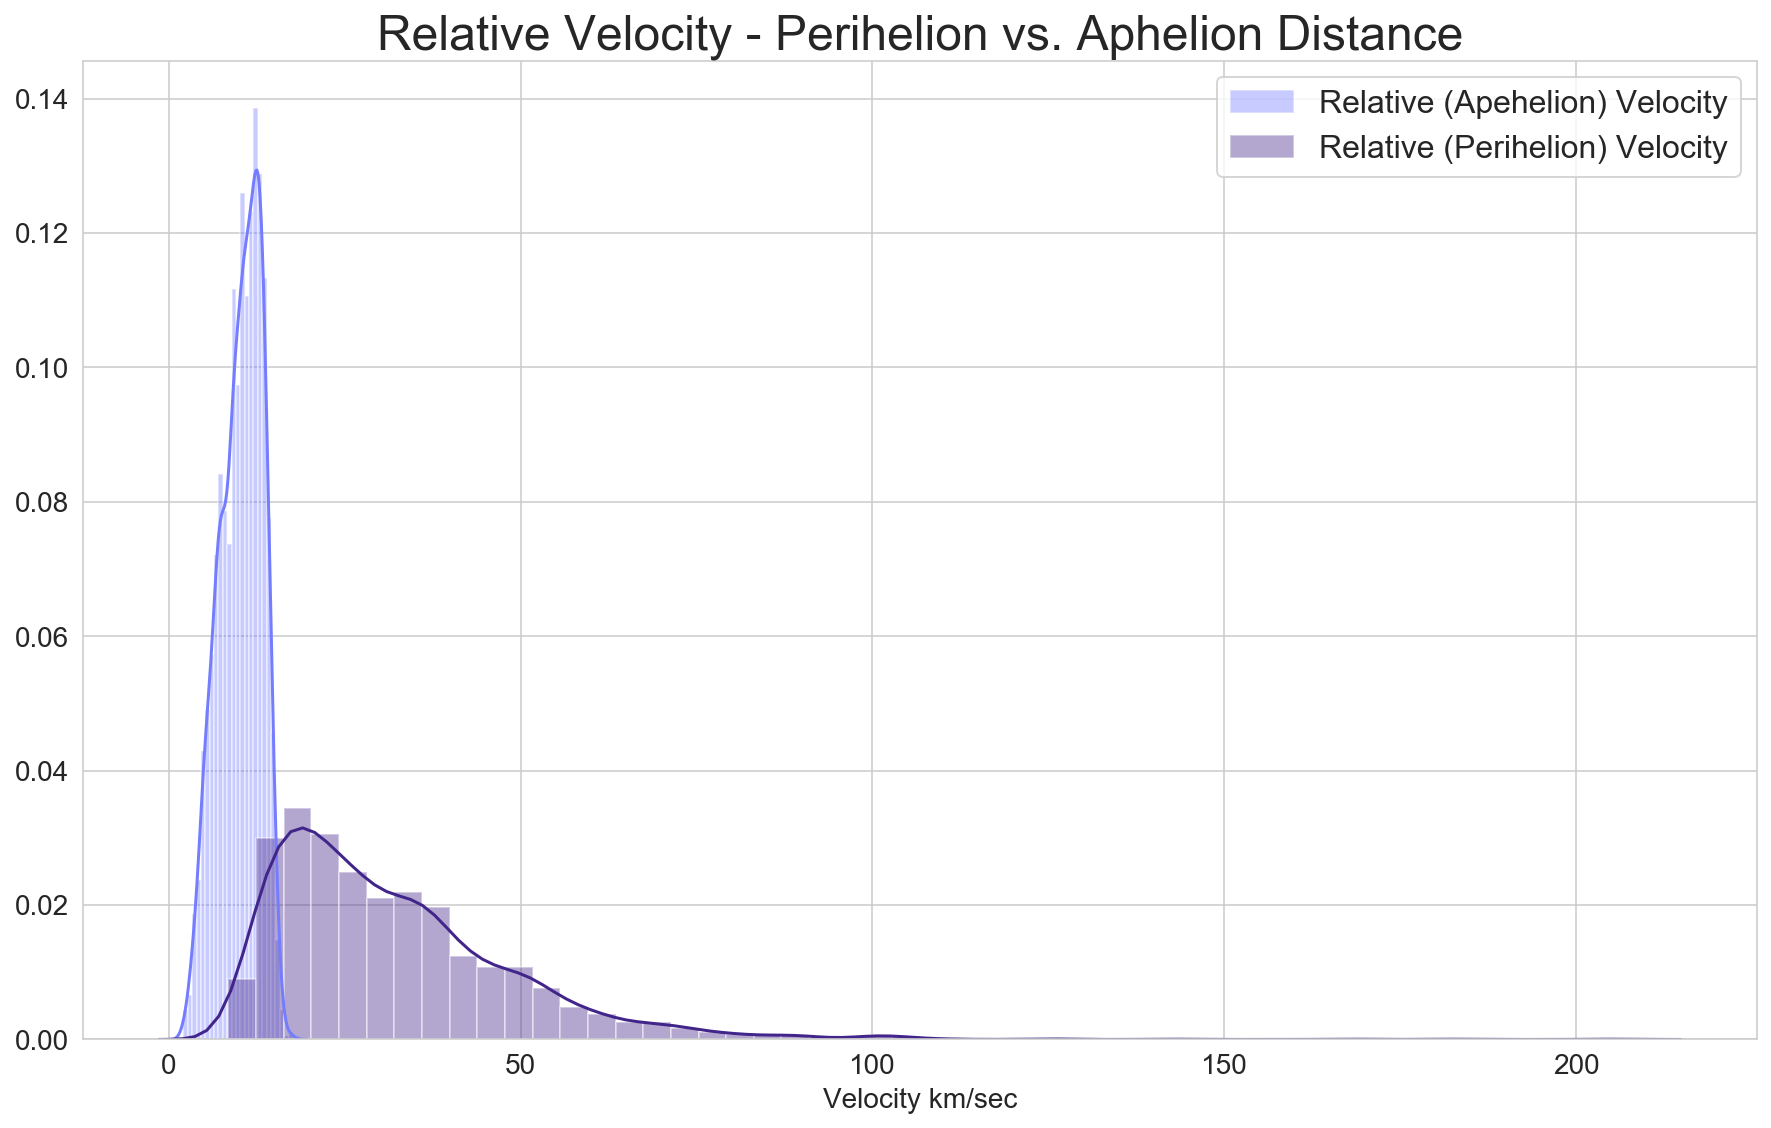

In [1054]:
sns.distplot(df['rel_velocity_Q'], color=c[1])
sns.distplot(df['rel_velocity_q'], color=c[4]);
plt.title('Relative Velocity - Perihelion vs. Aphelion Distance', fontsize=24)
plt.xlabel('Velocity km/sec')
# plt.ylabel(f'Frequency x {10**4}')
plt.legend(['Relative (Apehelion) Velocity', 'Relative (Perihelion) Velocity'], fontsize =16);
plt.savefig('../images/relative_velocity.png');

In [1055]:
df['rel_velocity_Q'].describe()

count    2917.000000
mean       10.223532
std         2.941185
min         2.066715
25%         8.017957
50%        10.594834
75%        12.583321
max        17.641962
Name: rel_velocity_Q, dtype: float64

In [1056]:
df['rel_velocity_q'].describe()

count    2917.000000
mean       31.805156
std        17.251645
min         8.468290
25%        19.055314
50%        27.858606
75%        39.748586
max       204.995086
Name: rel_velocity_q, dtype: float64

In [1057]:
df.dtypes

neo                                     int64
hazardous                               int64
epoch_cal                             float64
eccentricity_(e)                      float64
semi_major_axis_(a)                   float64
perihelion_dist_(q)                   float64
inclination_(i)                       float64
perihelion_arg_(w)                    float64
abs_magnitude_(H)                     float64
mean_anomaly                          float64
aphelion_dist_(Q)                     float64
mean_motion_(n)                       float64
min_orbit_intersection_dist           float64
t_jupiter                             float64
asc_node_long_(deg)                   float64
orbital_per_(y)                       float64
first_obs                      datetime64[ns]
last_obs                       datetime64[ns]
class_APO                               uint8
class_ATE                               uint8
class_IEO                               uint8
stand_grav_param                  

In [1058]:
df.isnull().sum()

neo                            0
hazardous                      0
epoch_cal                      0
eccentricity_(e)               0
semi_major_axis_(a)            0
perihelion_dist_(q)            0
inclination_(i)                0
perihelion_arg_(w)             0
abs_magnitude_(H)              0
mean_anomaly                   0
aphelion_dist_(Q)              0
mean_motion_(n)                0
min_orbit_intersection_dist    0
t_jupiter                      0
asc_node_long_(deg)            0
orbital_per_(y)                0
first_obs                      0
last_obs                       0
class_APO                      0
class_ATE                      0
class_IEO                      0
stand_grav_param               0
rel_velocity_Q                 0
rel_velocity_q                 0
dtype: int64

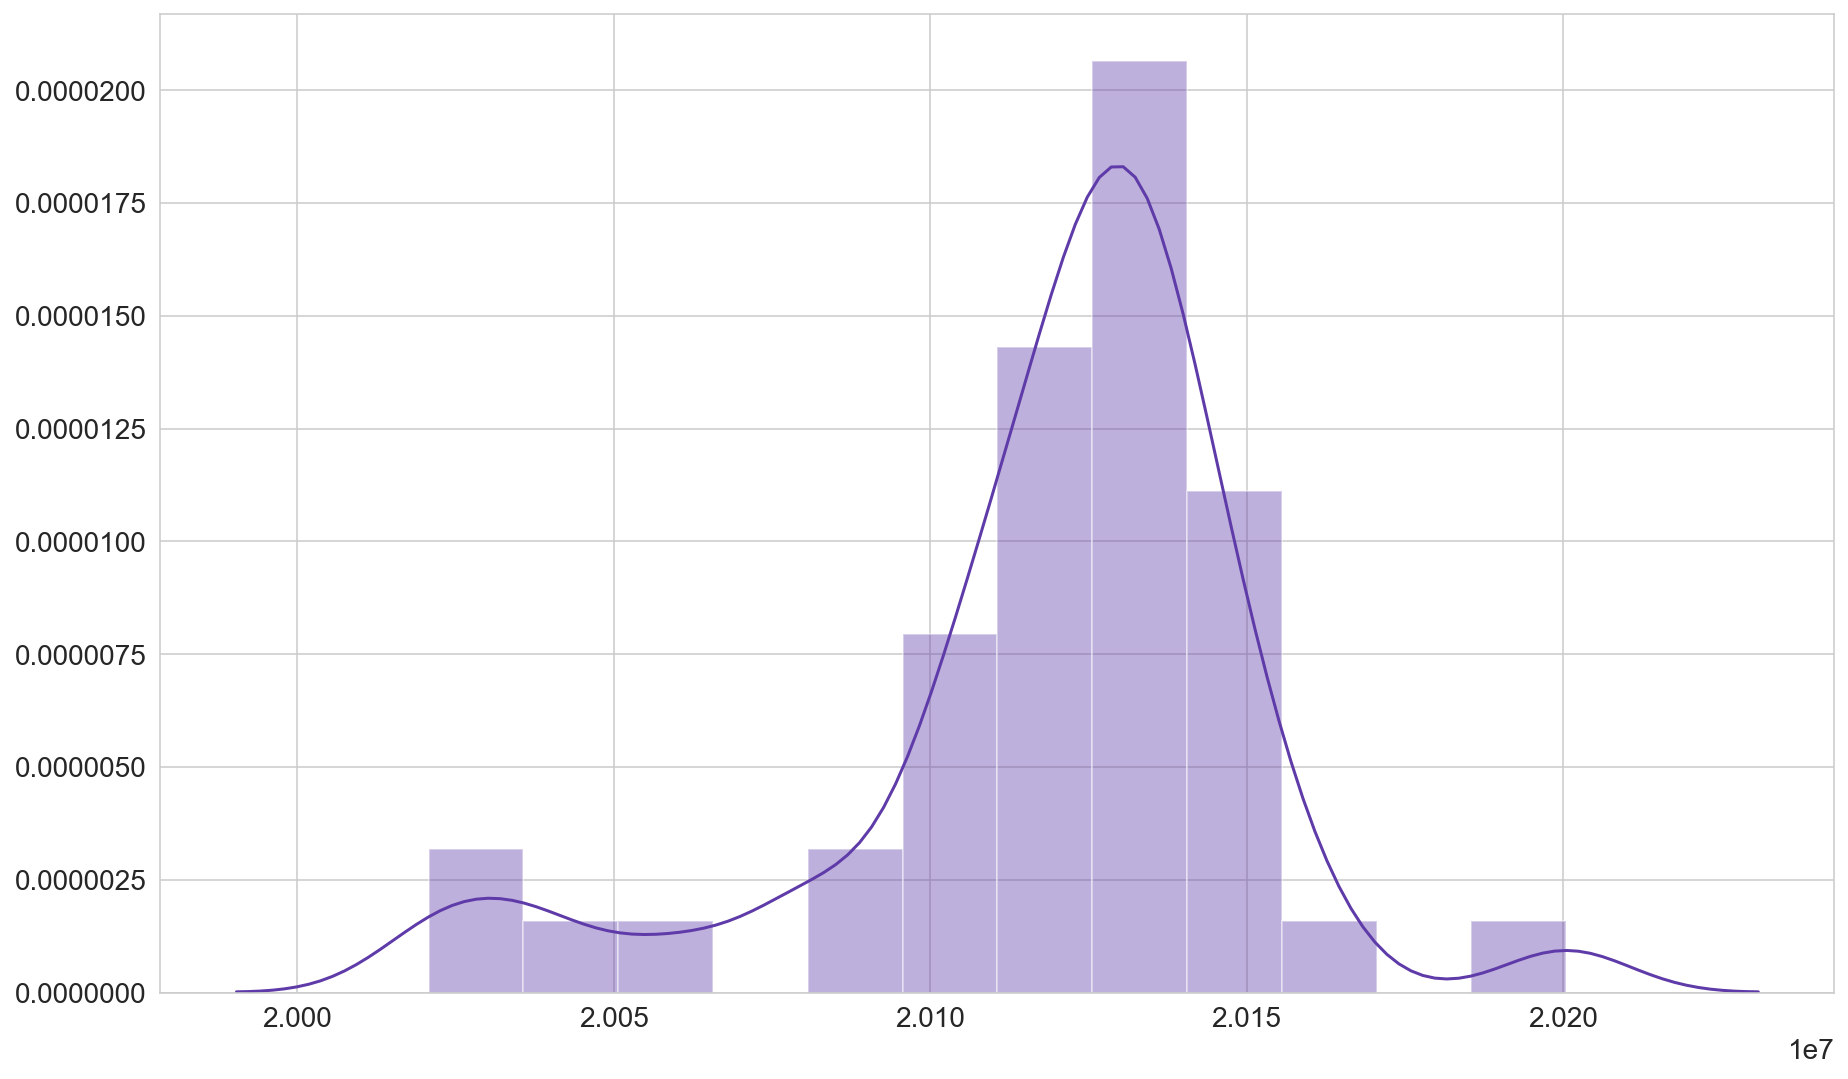

In [1059]:
sns.distplot(df['epoch_cal'].unique(), color=c[2])

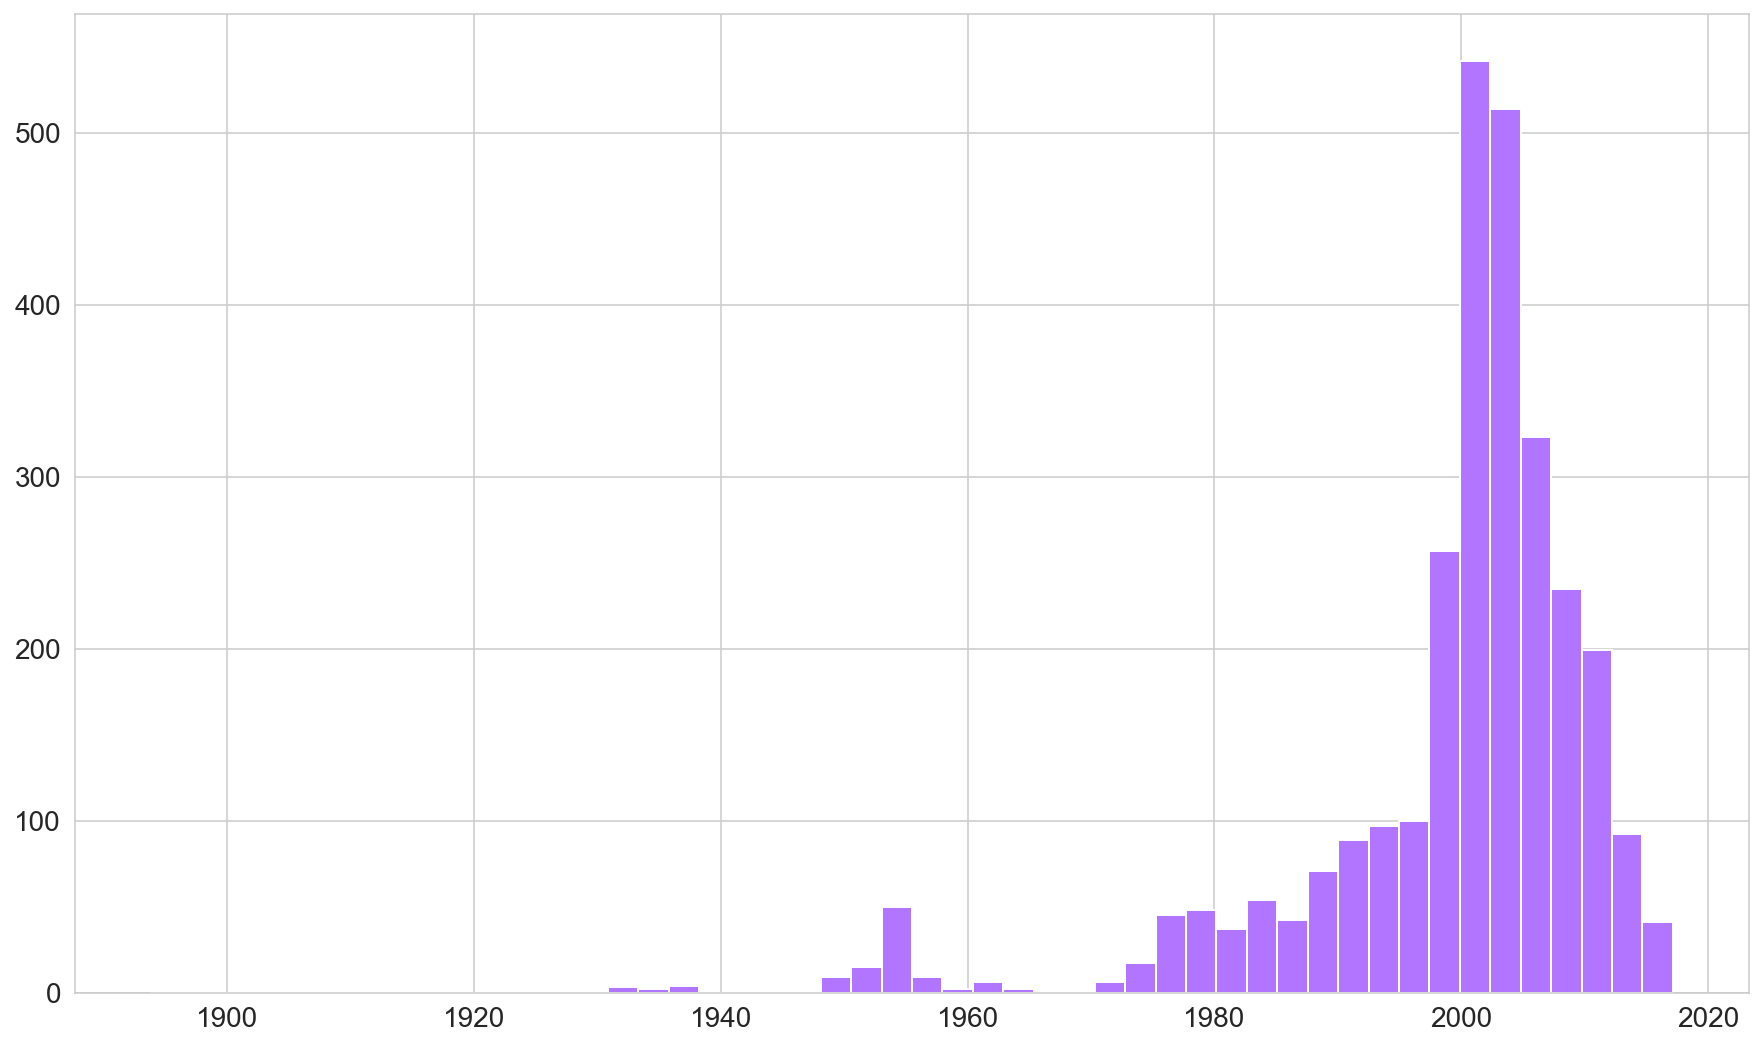

In [1060]:
df['first_obs'].hist(bins=50, color=c[0])

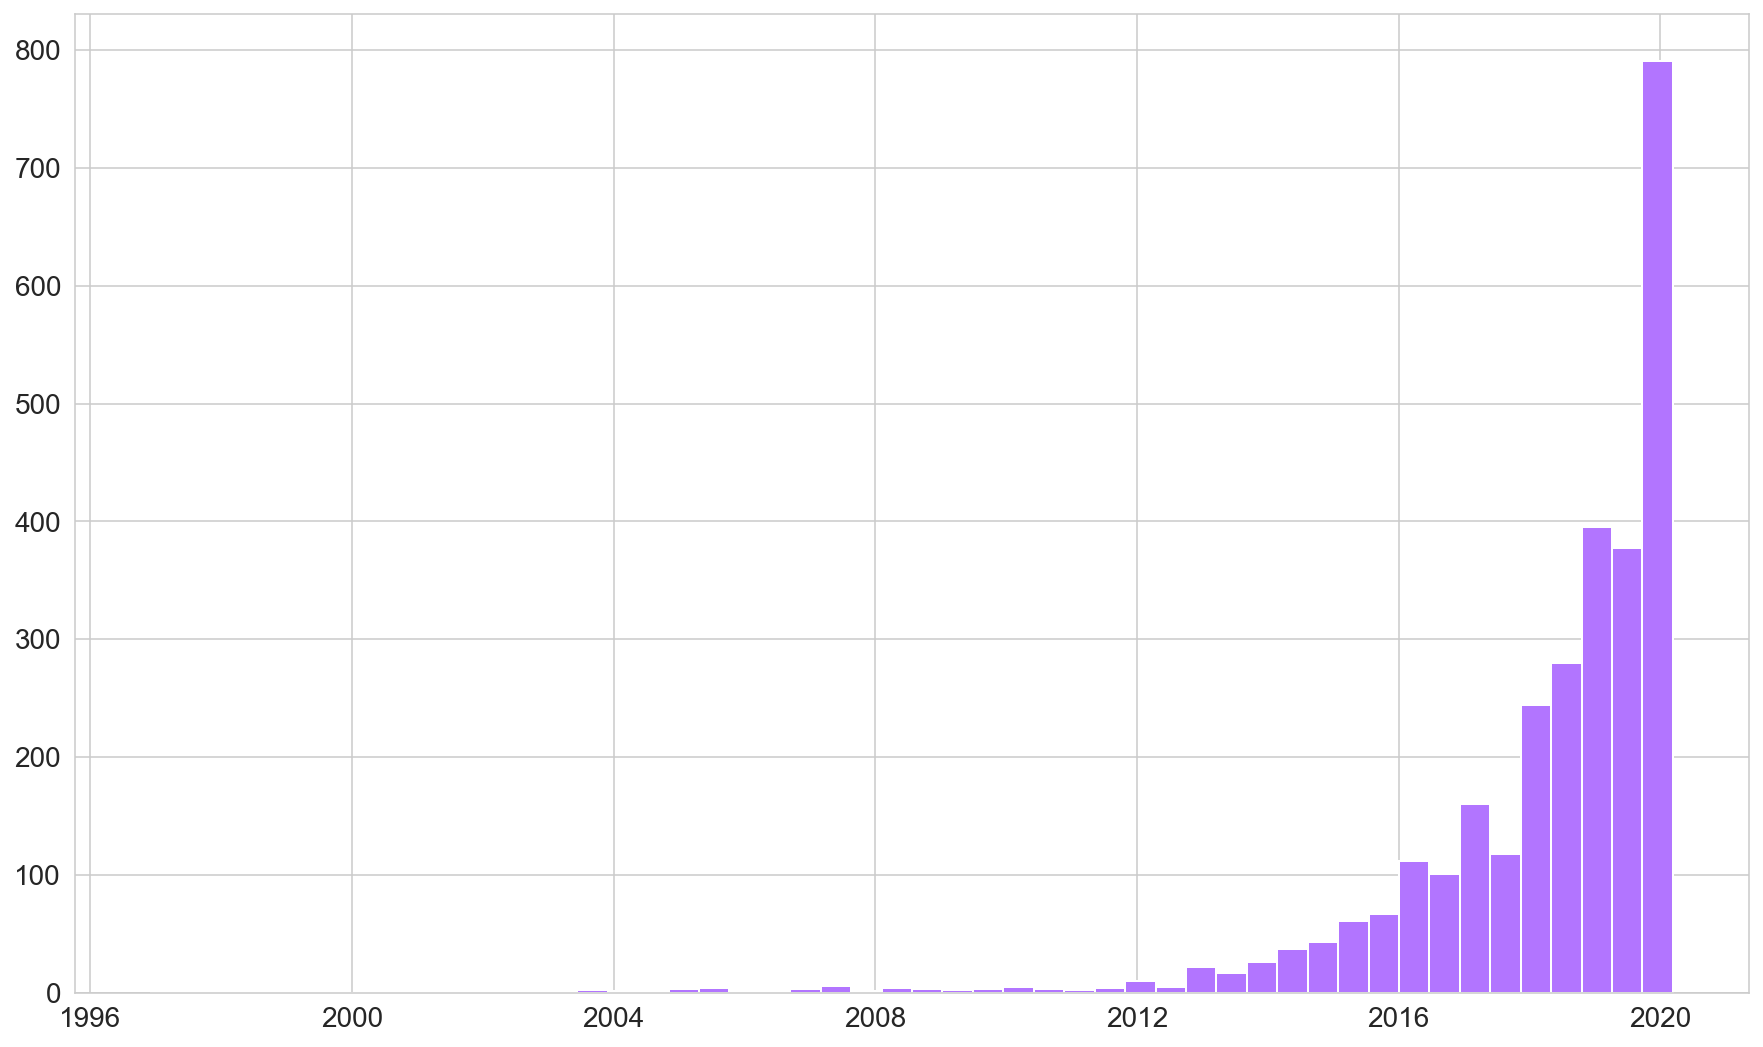

In [1061]:
df['last_obs'].hist(bins=50, color=c[0])

In [1062]:
cols = list(df.columns)
cols

['neo',
 'hazardous',
 'epoch_cal',
 'eccentricity_(e)',
 'semi_major_axis_(a)',
 'perihelion_dist_(q)',
 'inclination_(i)',
 'perihelion_arg_(w)',
 'abs_magnitude_(H)',
 'mean_anomaly',
 'aphelion_dist_(Q)',
 'mean_motion_(n)',
 'min_orbit_intersection_dist',
 't_jupiter',
 'asc_node_long_(deg)',
 'orbital_per_(y)',
 'first_obs',
 'last_obs',
 'class_APO',
 'class_ATE',
 'class_IEO',
 'stand_grav_param',
 'rel_velocity_Q',
 'rel_velocity_q']

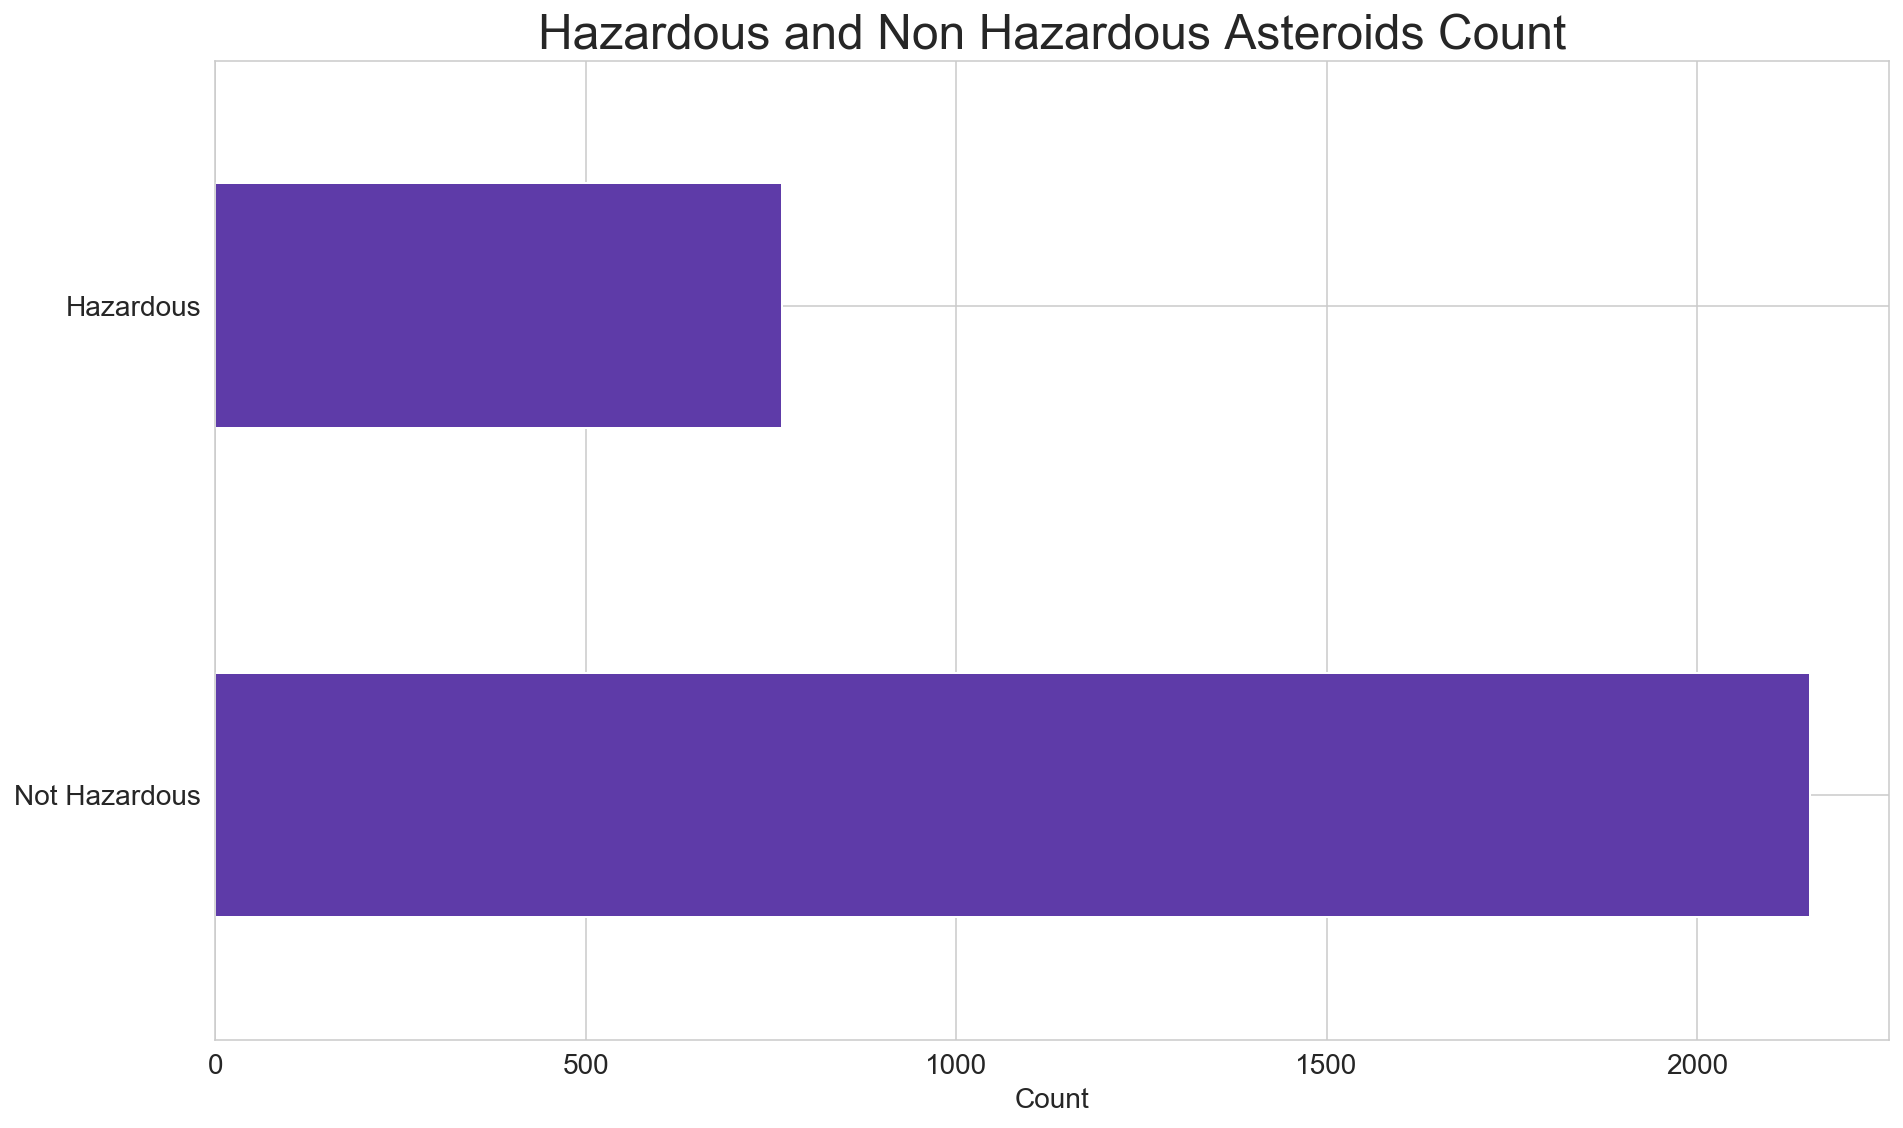

In [1065]:
df['hazardous'].value_counts().plot(kind='barh', color=c[2])
plt.yticks(ticks = np.arange(2), labels=['Not Hazardous', 'Hazardous']);
plt.title('Hazardous and Non Hazardous Asteroids Count', size=24);
plt.xlabel('Count')
plt.savefig('../images/class_count.png');

### Pickle Cleaned Data

In [1067]:
import pickle

pickle.dump(df, open("../assets/clean_df.pkl", "wb"))